# Sprawozdanie z **Obliczeń ewolucyjnych**
## Zadanie 2 

In [49]:
!pip install deap > /dev/null
!pip install matplotlib > /dev/null
!pip install tabulate > /dev/null
# !pip install k3d > /dev/null
%matplotlib notebook

<div>Setting styles</div>
<style>
div.ui-dialog-titlebar.ui-widget-header {display: none;}
</style>
<style>
div.ui-dialog-titlebar {display: none;}
</style>

In [95]:
HTML("<style>div.inline {display: inline-block; padding: 0;}</style>")

## Configuration

### Imports

In [96]:
from tabulate import tabulate
from IPython.display import display, HTML
import itertools
import math
import operator
import random
from statistics import mean
import time

import numpy
np = numpy
from deap import base
from deap.benchmarks import movingpeaks
from deap import creator
from deap import tools

#plots
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from functools import reduce
#random
from numpy import random as nrand
nrand.seed(0)
from random import seed
seed(0)
#constants
COLUMN_HIGHLIGHT='#9AD10F'

In [121]:
from pathlib import Path
import json

class Config(object): 
    def __init__(self, TYPE, CHI, C, P, BOA_C, BOA_A, DIST, DIMS, NSWARMS, NPARTICLES, NEXCESS, RCLOUD, EVALS):
        self.CHI = CHI        
        self.TYPE = TYPE
        self.C = C
        self.P = P
        self.BOA_C = BOA_C
        self.BOA_A = BOA_A
        self.DIST = DIST
        self.DIMS = DIMS
        self.NSWARMS = NSWARMS
        self.NPARTICLES = NPARTICLES
        self.NEXCESS = NEXCESS
        self.RCLOUD = RCLOUD
        self.EVALS = EVALS

def as_config(dct):
    return Config(
        dct['TYPE'],        
        dct['CHI'],
        dct['C'],
        dct['P'],
        dct['BOA_C'],
        dct['BOA_A'],
        dct['DIST'],
        dct['DIMS'],
        dct['NSWARMS'],
        dct['NPARTICLES'], 
        dct['NEXCESS'], 
        dct['RCLOUD'],
        dct['EVALS'],
        )

load_config = lambda : json.loads(json_config, object_hook = as_config)

def cstr(s, color='black'):
    return "<text style=color:{}>{}</text>".format(color, s)

colorize = lambda text, patterns: reduce(lambda a,b: a.replace(b, cstr(b, color=COLUMN_HIGHLIGHT)) , patterns, text)
colorize_column = lambda table, col_name: colorize(table, [col_name])
def tabulate_config(col_name=None):
    table = tabulate([[cfg.CHI, cfg.TYPE, cfg.C, cfg.P, cfg.DIST, cfg.DIMS, cfg.NSWARMS, cfg.NPARTICLES, cfg.NEXCESS, cfg.RCLOUD]],
                     headers=["CHI", "TYPE", "C", "P", "DIST", "DIMS", "NSWARMS", "NPARTICLES", "NEXCESS", "RCLOUD"],
                     tablefmt="html")
    if col_name:
        display(HTML(colorize_column(table, col_name)))
    else:
        display(HTML(table))

### Plots

In [98]:
flatten = lambda l: [item for sublist in l for item in sublist]
figsize = (14, 8)
def annot_min(x,y, ax=None, x_pos_mod=1, y_pos_mod=-0.06):
    xmin = x[np.argmin(y)]
    ymin = y.min()
    text= "x={:.3f}, y={:.3f}".format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops,
              bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmin, ymin), xytext=(0.5,-0.02), **kw)

def hist_over_time(result_book, single_gen_index=None,
                   min_hist_value=1, sift_rate=100,
                   skip_first=100, limits=(-250, 70)):
    hists = result_book.select("hist")
    hists = hists[skip_first:] # skip first 100 evals
    hists = hists[0::sift_rate] # take one in 4
    hists = [h for h in hists if h]
    all_z_points = flatten([a[0].tolist() for a in hists])
    all_x_points = flatten([((a[1][1:] + a[1][:-1])/2).tolist() for a in hists])
    all_y_points = flatten([np.full(len(x[1]), x[0]) for x in [(a,hists[a][0]) for a in range(len(hists))]])
    size =  len(all_z_points)
    p = 0
    while p < size:
        if all_z_points[p] < min_hist_value:
            del all_z_points[p]
            del all_x_points[p]
            del all_y_points[p]
            size = size - 1
            p = p - 1
        p = p + 1
    fig = plt.figure(figsize=figsize, dpi=100)
    ax = plt.axes(projection="3d", title="Value of particles fitness's histogram across generations (in Z)")
    ax.scatter3D(all_x_points, all_y_points, all_z_points, c=all_z_points, cmap='inferno');
    ax.set_xlim(limits[0], limits[1])
    plt.show()

    if single_gen_index:
        res = np.array(result_book.select("hist")[single_gen_index])
        z_points = res[0]
        x_points = (res[1][1:] + res[1][:-1])/2
        y_points = np.zeros(len(z_points))
        fig = plt.figure()
        ax = plt.axes(projection="3d")
        ax.scatter3D(x_points, y_points, z_points, c=y_points, cmap='inferno');
        plt.show()
        
def plots_nswarms(result_book, top_limit=10):
    swarms = result_book.select("nswarm")
    swarms = [s for s in swarms]
    fig = plt.figure(figsize=figsize, dpi=50)
    ax = plt.axes(title="Number of swarms across generations")
    ax.set_ylim(0, top_limit)
    ax.scatter(range(len(swarms)), swarms, c=swarms, cmap='copper');
    plt.show()

def plot_titled(y, ax, title):
    ax.set_title(title)
    ax.scatter(range(len(y)), y, c=y, cmap='coolwarm');
    annot_min(range(len(y)), y, ax=ax)
    plt.show()

def plot_offline_error(result_book):
    off_error = result_book.select("offline_error")
    off_error = np.array(off_error)

    fig = plt.figure(figsize=figsize, dpi=55)
    ax = plt.axes(title="Offline error across generations")
    ax.scatter(range(len(off_error)), off_error, c=off_error, cmap='coolwarm');
    annot_min(range(len(off_error)), off_error)
    plt.show()

def plot_error(result_book):
    error = result_book.select("error")
    error = np.array(error)
    fig = plt.figure(figsize=figsize, dpi=50)
    ax = plt.axes(title="Error across generations")
    # ax.scatter(range(len(error)), error, s=10, c=error, cmap='coolwarm')
    ax.plot(range(len(error)), error)
    annot_min(range(len(error)), error)
    plt.show()

# Algorytmy MPSO, MSPSO oraz BOA

### Creator

In [99]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Particle", list, fitness=creator.FitnessMax, speed=list, 
    best=None, bestfit=creator.FitnessMax)
creator.create("Swarm", list, best=None, bestfit=creator.FitnessMax)

def generate(pclass, dim, pmin, pmax, smin, smax):
    part = pclass(random.uniform(pmin, pmax) for _ in range(dim)) 
    part.speed = [random.uniform(smin, smax) for _ in range(dim)]
    return part

### Update particles

In [144]:
def convertQuantum(swarm, rcloud, centre):
    dim = len(swarm[0])
    for part in swarm:
        position = [random.gauss(0, 1) for _ in range(dim)]
        dist = math.sqrt(sum(x**2 for x in position))
        
        if cfg.DIST == "gaussian":
            u = abs(random.gauss(0, 1.0/3.0))
            part[:] = [(rcloud * x * u**(1.0/dim) / dist) + c for x, c in zip(position, centre)]
        
        elif cfg.DIST == "uvd":
            u = random.random()
            part[:] = [(rcloud * x * u**(1.0/dim) / dist) + c for x, c in zip(position, centre)]
        
        elif cfg.DIST == "nuvd":
            u = abs(random.gauss(0, 1.0/3.0))
            part[:] = [(rcloud * x * u / dist) + c for x, c in zip(position, centre)]
        
        del part.fitness.values
        del part.bestfit.values
        part.best = None
    
    return swarm

def updateParticleMPSO(part, best, chi, c):
    ce1 = (c * random.uniform(0, 1) for _ in range(len(part)))
    ce2 = (c * random.uniform(0, 1) for _ in range(len(part)))
    ce1_p = map(operator.mul, ce1, map(operator.sub, best, part))
    ce2_g = map(operator.mul, ce2, map(operator.sub, part.best, part))
    a = map(operator.sub,
                      map(operator.mul,
                                    itertools.repeat(chi),
                                    map(operator.add, ce1_p, ce2_g)),
                      map(operator.mul,
                                     itertools.repeat(1 - chi),
                                     part.speed))
    part.speed = list(map(operator.add, part.speed, a))
    part[:] = list(map(operator.add, part, part.speed))
    part[:] = [BOUNDS[0] if v < BOUNDS[0] else BOUNDS[1] if v > BOUNDS[1] else v for v in part[:]]

def updateParticleMSPSO(part, best, chi, c):
    ce1 = (c * random.uniform(0, 1) for _ in range(len(part)))
    ce2 = (c * random.uniform(0, 1) for _ in range(len(part)))
    ce1_p = map(operator.mul, ce1, map(operator.sub, best, part))
    ce2_g = map(operator.mul, ce2, map(operator.sub, part.best, part))
    a = map(operator.sub,
                      map(operator.mul,
                                    itertools.repeat(chi),
                                    map(operator.add, ce1_p, ce2_g)),
                      map(operator.mul,
                                     itertools.repeat(1 - chi),
                                     part.speed))
    part.speed = list(map(operator.add, part.speed, a))
    part[:] = list(map(operator.add, part, part.speed))
    part[:] = [BOUNDS[0] if v < BOUNDS[0] else BOUNDS[1] if v > BOUNDS[1] else v for v in part[:]]
    
def updateEliteParticles(population):
    for updateSwarm in population:
        lbest = [swarm[0] for swarm in population if swarm != updateSwarm]
        mean = np.mean(lbest, axis=0)
        N = nrand.uniform(1, 2, len(updateSwarm.best))
        updateSwarm[0][:] = list(map(operator.mul,
                           mean,
                           N))
from math import pow
def updateParticleBOA(rand_part_1, rand_part_2, part, best, c, a, p):
    r = random.uniform(0, 1)
    fragrance = c*(pow(part.fitness.values[0], a))
    r1 = (r**2 * rand_part_1[i] - rand_part_2[i] for i in range(len(part)))
    if r < p:
        move = map(operator.mul,
                map(operator.sub,
                      map(operator.mul,
                                    itertools.repeat(r**2),
                                    best),
                    part),
                itertools.repeat(fragrance))
    else:
        move = map(operator.mul,
                   itertools.repeat(fragrance),
                   r1)
    part[:] = list(map(operator.add, part, move))
    part[:] = [BOUNDS[0] if v < BOUNDS[0] else BOUNDS[1] if v > BOUNDS[1] else v for v in part[:]]

### Toolbox

In [142]:
def setup_toolbox(BOUNDS, mpb):    
    toolbox = base.Toolbox()
    toolbox.register("particle", generate, creator.Particle, dim=cfg.DIMS,
        pmin=BOUNDS[0], pmax=BOUNDS[1], smin=-(BOUNDS[1] - BOUNDS[0])/2.0,
        smax=(BOUNDS[1] - BOUNDS[0])/2.0)
    toolbox.register("swarm", tools.initRepeat, creator.Swarm, toolbox.particle)
    if cfg.TYPE == "MPSO":
        toolbox.register("update", updateParticleMPSO, chi=cfg.CHI, c=cfg.C)
    elif cfg.TYPE == "MSPSO":
        toolbox.register("update", updateParticleMSPSO, chi=cfg.CHI, c=cfg.C)
    elif cfg.TYPE == "BOA":
        toolbox.register("update", updateParticleBOA, p=cfg.P)
    else:
        toolbox.register("update", updateParticleMPSO, chi=cfg.CHI, c=cfg.C)
    toolbox.register("convert", convertQuantum)
    toolbox.register("evaluate", mpb)
    toolbox.register("eliteupdate", updateEliteParticles)
    return toolbox

### Algorithms bodies in App class

<div style="text-align: justify">
<h4>MPSO</h4>
    
<h4>MSPSO</h4>
    
<h4>BOA</h4>
</div>

In [127]:
class App():
    def register_stats(self, should_plot):
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", numpy.mean)
        stats.register("std", numpy.std)
        stats.register("min", numpy.min)
        stats.register("max", numpy.max)        
        logbook = tools.Logbook()
        if should_plot:
            stats.register("hist", lambda a: numpy.histogram(a, bins="auto"))
            logbook.header = "gen", "nswarm", "evals", "error", "offline_error", "avg", "max", "hist"
        else:
            logbook.header = "gen", "nswarm", "evals", "error", "offline_error", "avg", "max"
        return stats, logbook
    
    
    def boa(self, should_plot):
        scenario = movingpeaks.SCENARIO_1
        global BOUNDS
        BOUNDS = [scenario["min_coord"], scenario["max_coord"]]
        mpb = movingpeaks.MovingPeaks(dim=cfg.DIMS, **scenario)
        toolbox = setup_toolbox(BOUNDS, mpb)
        stats, logbook = self.register_stats(should_plot)

        # Generate the initial population
        population = [toolbox.swarm(n=cfg.NPARTICLES) for _ in range(cfg.NSWARMS)]

        # Evaluate each particle
        for swarm in population:
            for part in swarm:
                part.fitness.values = toolbox.evaluate(part)
                if not swarm.best or part.fitness > swarm.bestfit:
                    swarm.best = toolbox.clone(part[:])         # Get the position
                    swarm.bestfit.values = part.fitness.values  # Get the fitness
        record = stats.compile(itertools.chain(*population))
        logbook.record(gen=0, evals=mpb.nevals, nswarm=len(population),
                       error=mpb.currentError(), offline_error=mpb.offlineError(), **record)

        generation = 1
        while mpb.nevals < cfg.EVALS:
            rexcl = (BOUNDS[1] - BOUNDS[0]) / (2 * len(population)**(1.0/cfg.DIMS))
            # Update and evaluate the swarm
            for swarm in population:
                #detect change
                if swarm.best and toolbox.evaluate(swarm.best) != swarm.bestfit.values:
                    swarm.best = None
                    del swarm.bestfit.values
                swarm.best = None
                for part in swarm:
                    part.fitness.values = toolbox.evaluate(part)
                    # Update global best
                    if not swarm.best or part.fitness > swarm.bestfit:
                        swarm.best = toolbox.clone(part[:])
                        swarm.bestfit.values = part.fitness.values
                for part in swarm:
                    toolbox.update(random.choice(swarm), random.choice(swarm), part, swarm.best, cfg.BOA_C, cfg.BOA_A)

            record = stats.compile(itertools.chain(*population))
            logbook.record(gen=generation, evals=mpb.nevals, nswarm=len(population),
                           error=mpb.currentError(), offline_error=mpb.offlineError(), **record)
                        # Apply exclusion
#             reinit_swarms = set()
#             for s1, s2 in itertools.combinations(range(len(population)), 2):
#                 # Swarms must have a best and not already be set to reinitialize
#                 if population[s1].best and population[s2].best and not (s1 in reinit_swarms or s2 in reinit_swarms):
#                     dist = 0
#                     for x1, x2 in zip(population[s1].best, population[s2].best):
#                         dist += (x1 - x2)**2.
#                     dist = math.sqrt(dist)
#                     if dist < rexcl:
#                         if population[s1].bestfit <= population[s2].bestfit:
#                             reinit_swarms.add(s1)
#                         else:
#                             reinit_swarms.add(s2)

#             # Reinitialize and evaluate swarms
#             for s in reinit_swarms:
#                 population[s] = toolbox.swarm(n=cfg.NPARTICLES)
#                 for part in population[s]:
#                     part.fitness.values = toolbox.evaluate(part)
#                     # Update swarm's attractors personal best and global best
#                     if not part.best or part.fitness > part.bestfit:
#                         part.best = toolbox.clone(part[:])
#                         part.bestfit.values = part.fitness.values
#                     if not population[s].best or part.fitness > population[s].bestfit:
#                         population[s].best = toolbox.clone(part[:])
#                         population[s].bestfit.values = part.fitness.values
            a=a+(0.025/(a*generation))
            generation += 1
        return logbook

    def mspso(self, should_plot):
        verbose=False
        scenario = movingpeaks.SCENARIO_1
        global BOUNDS
        BOUNDS = [scenario["min_coord"], scenario["max_coord"]]
        mpb = movingpeaks.MovingPeaks(dim=cfg.DIMS, **scenario)
        toolbox = setup_toolbox(BOUNDS, mpb)
        stats, logbook = self.register_stats(should_plot)

        # Generate the initial population
        population = [toolbox.swarm(n=cfg.NPARTICLES) for _ in range(cfg.NSWARMS)]

        # Evaluate each particle
        for swarm in population:
            elite_part_index = None
            for i, part in enumerate(swarm):
                part.fitness.values = toolbox.evaluate(part)
                # Find elite particle
                if not elite_part_index or swarm[elite_part_index].bestfit < part.bestfit:
                    elite_part_index = i
                # Update swarm's attractors personal best and global best
                if not part.best or part.fitness > part.bestfit:
                    part.best = toolbox.clone(part[:])          # Get the position
                    part.bestfit.values = part.fitness.values   # Get the fitness
                if not swarm.best or part.fitness > swarm.bestfit:
                    swarm.best = toolbox.clone(part[:])         # Get the position
                    swarm.bestfit.values = part.fitness.values  # Get the fitness
            swarm[0], swarm[elite_part_index] = swarm[elite_part_index], swarm[0]
        record = stats.compile(itertools.chain(*population))
        logbook.record(gen=0, evals=mpb.nevals, nswarm=len(population),
                       error=mpb.currentError(), offline_error=mpb.offlineError(), **record)

        if verbose:
            print(logbook.stream)

        generation = 1
        while mpb.nevals < cfg.EVALS:
            # Check for convergence
            rexcl = (BOUNDS[1] - BOUNDS[0]) / (2 * len(population)**(1.0/cfg.DIMS))

            toolbox.eliteupdate(population)
            
            # Update and evaluate the swarm
            for swarm in population:
                # Check for change
                if swarm.best and toolbox.evaluate(swarm.best) != swarm.bestfit.values:
                    # Convert particles to quantum particles
                    swarm[:] = toolbox.convert(swarm, rcloud=cfg.RCLOUD, centre=swarm.best)
                    swarm.best = None
                    del swarm.bestfit.values
                elite_part_index = None
                for i, part in enumerate(swarm):
                    # Not necessary to update if it is a new swarm
                    # or a swarm just converted to quantum
                    if swarm.best and part.best and i != 0:
                        toolbox.update(part, swarm.best)
                    part.fitness.values = toolbox.evaluate(part)
                    # Find elite particle
                    if not elite_part_index or swarm[elite_part_index].bestfit < part.bestfit:
                        elite_part_index = i
                    # Update swarm's attractors personal best and global best
                    if not part.best or part.fitness > part.bestfit:
                        part.best = toolbox.clone(part[:])
                        part.bestfit.values = part.fitness.values
                    if not swarm.best or part.fitness > swarm.bestfit:
                        swarm.best = toolbox.clone(part[:])
                        swarm.bestfit.values = part.fitness.values
                swarm[0], swarm[elite_part_index] = swarm[elite_part_index], swarm[0]
            record = stats.compile(itertools.chain(*population))
            logbook.record(gen=generation, evals=mpb.nevals, nswarm=len(population),
                           error=mpb.currentError(), offline_error=mpb.offlineError(), **record)

            if verbose:
                print(logbook.stream)

            # Apply exclusion
            reinit_swarms = set()
            for s1, s2 in itertools.combinations(range(len(population)), 2):
                # Swarms must have a best and not already be set to reinitialize
                if population[s1].best and population[s2].best and not (s1 in reinit_swarms or s2 in reinit_swarms):
                    dist = 0
                    for x1, x2 in zip(population[s1].best, population[s2].best):
                        dist += (x1 - x2)**2.
                    dist = math.sqrt(dist)
                    if dist < rexcl:
                        if population[s1].bestfit <= population[s2].bestfit:
                            reinit_swarms.add(s1)
                        else:
                            reinit_swarms.add(s2)

            # Reinitialize and evaluate swarms
            for s in reinit_swarms:
                population[s] = toolbox.swarm(n=cfg.NPARTICLES)
                for part in population[s]:
                    part.fitness.values = toolbox.evaluate(part)

                    # Update swarm's attractors personal best and global best
                    if not part.best or part.fitness > part.bestfit:
                        part.best = toolbox.clone(part[:])
                        part.bestfit.values = part.fitness.values
                    if not population[s].best or part.fitness > population[s].bestfit:
                        population[s].best = toolbox.clone(part[:])
                        population[s].bestfit.values = part.fitness.values
            generation += 1
        return logbook
    def mpso(self, should_plot):
        verbose=True
        scenario = movingpeaks.SCENARIO_1
        global BOUNDS
        BOUNDS = [scenario["min_coord"], scenario["max_coord"]]
        mpb = movingpeaks.MovingPeaks(dim=cfg.DIMS, **scenario)
        toolbox = setup_toolbox(BOUNDS, mpb)
        stats, logbook = self.register_stats(should_plot)

        # Generate the initial population
        population = [toolbox.swarm(n=cfg.NPARTICLES) for _ in range(cfg.NSWARMS)]
        # Evaluate each particle
        for swarm in population:
            for part in swarm:
                part.fitness.values = toolbox.evaluate(part)

                # Update swarm's attractors personal best and global best
                if not part.best or part.fitness > part.bestfit:
                    part.best = toolbox.clone(part[:])          # Get the position
                    part.bestfit.values = part.fitness.values   # Get the fitness
                if not swarm.best or part.fitness > swarm.bestfit:
                    swarm.best = toolbox.clone(part[:])         # Get the position
                    swarm.bestfit.values = part.fitness.values  # Get the fitness

        record = stats.compile(itertools.chain(*population))
        logbook.record(gen=0, evals=mpb.nevals, nswarm=len(population),
                       error=mpb.currentError(), offline_error=mpb.offlineError(), **record)

        generation = 1
        while mpb.nevals < cfg.EVALS:
            # Check for convergence
            rexcl = (BOUNDS[1] - BOUNDS[0]) / (2 * len(population)**(1.0/cfg.DIMS))

            not_converged = 0
            worst_swarm_idx = None
            worst_swarm = None
            for i, swarm in enumerate(population):
                # Compute the diameter of the swarm
                for p1, p2 in itertools.combinations(swarm, 2):
                    d = math.sqrt(sum((x1 - x2)**2. for x1, x2 in zip(p1, p2)))
                    if d > 2*rexcl:
                        not_converged += 1
                        # Search for the worst swarm according to its global best
                        if not worst_swarm or swarm.bestfit < worst_swarm.bestfit:
                            worst_swarm_idx = i
                            worst_swarm = swarm
                        break

            # If all swarms have converged, add a swarm
            if not_converged == 0:
                population.append(toolbox.swarm(n=cfg.NPARTICLES))
            # If too many swarms are roaming, remove the worst swarm
            elif not_converged > cfg.NEXCESS:
                population.pop(worst_swarm_idx)

            # Update and evaluate the swarm
            for swarm in population:
                # Check for change
                if swarm.best and toolbox.evaluate(swarm.best) != swarm.bestfit.values:
                    # Convert particles to quantum particles
                    swarm[:] = toolbox.convert(swarm, rcloud=cfg.RCLOUD, centre=swarm.best)
                    swarm.best = None
                    del swarm.bestfit.values

                for part in swarm:
                    # Not necessary to update if it is a new swarm
                    # or a swarm just converted to quantum
                    if swarm.best and part.best:
                        toolbox.update(part, swarm.best)
                    part.fitness.values = toolbox.evaluate(part)

                    # Update swarm's attractors personal best and global best
                    if not part.best or part.fitness > part.bestfit:
                        part.best = toolbox.clone(part[:])
                        part.bestfit.values = part.fitness.values
                    if not swarm.best or part.fitness > swarm.bestfit:
                        swarm.best = toolbox.clone(part[:])
                        swarm.bestfit.values = part.fitness.values

            record = stats.compile(itertools.chain(*population))
            logbook.record(gen=generation, evals=mpb.nevals, nswarm=len(population),
                           error=mpb.currentError(), offline_error=mpb.offlineError(), **record)

            # Apply exclusion
            reinit_swarms = set()
            for s1, s2 in itertools.combinations(range(len(population)), 2):
                # Swarms must have a best and not already be set to reinitialize
                if population[s1].best and population[s2].best and not (s1 in reinit_swarms or s2 in reinit_swarms):
                    dist = 0
                    for x1, x2 in zip(population[s1].best, population[s2].best):
                        dist += (x1 - x2)**2.
                    dist = math.sqrt(dist)
                    if dist < rexcl:
                        if population[s1].bestfit <= population[s2].bestfit:
                            reinit_swarms.add(s1)
                        else:
                            reinit_swarms.add(s2)

            # Reinitialize and evaluate swarms
            for s in reinit_swarms:
                population[s] = toolbox.swarm(n=cfg.NPARTICLES)
                for part in population[s]:
                    part.fitness.values = toolbox.evaluate(part)

                    # Update swarm's attractors personal best and global best
                    if not part.best or part.fitness > part.bestfit:
                        part.best = toolbox.clone(part[:])
                        part.bestfit.values = part.fitness.values
                    if not population[s].best or part.fitness > population[s].bestfit:
                        population[s].best = toolbox.clone(part[:])
                        population[s].bestfit.values = part.fitness.values
            generation += 1
        return logbook
    def run(self, should_plot=True):
        start_time = time.time()
        result = None
        if cfg.TYPE == "MPSO":
            result = self.mpso(should_plot)
        elif cfg.TYPE == "MSPSO":
            result = self.mspso(should_plot)
        elif cfg.TYPE == "BOA":
            result = self.boa(should_plot)
        else:
            result = self.mpso(should_plot)
        if should_plot:
            print("--- Mean offline error %.4f ---" % np.mean(result.select("offline_error")))
            plot_results(result)
        return result, (time.time() - start_time)
def plot_results(logbook):
        hist_over_time(logbook)
        plots_nswarms(logbook, top_limit=cfg.NSWARMS*2)
        plot_offline_error(logbook)
        plot_error(logbook)

def plot_means_from_runs(runs, names):
    fig, axes = plt.subplots(len(names), 1, sharex=True, figsize=(10,8))
    for i, col_name in enumerate(names):
        min_len = np.min([len(v[0].select(col_name)) for v in runs])
        values = [x[0].select(col_name)[0:min_len] for x in runs]
        mean_values = np.mean(values, axis=0)
        plot_titled(mean_values, axes[i], f"Mean {col_name} across generations taken from {len(runs)} runs")

def run_n_times(n, col_name=None):
    tabulate_config(col_name)
    results = [App().run(should_plot=False) for _ in range(n)]
    print("--- Mean computation time %.4f seconds ---" % np.mean([x[1] for x in results]))
    print("--- Mean offline error %.4f ---" % np.mean(flatten(x[0].select("offline_error") for x in results)))
    plot_means_from_runs(results, ["offline_error", "error"])

# Badania

Konfiguracja wspólna dla wszystkich testów:
* n_runs - ilość uruchomień danego algorytmu w ramach jednego testu
* json_config - domyślne wartości parametrów algorytmów

In [122]:
n_runs = 25
json_config ="""
{
    "TYPE": "MPSO",
    "CHI": 0.729843788,
    "C": 2.05,
    "BOA_C": 0.01,
    "BOA_A": 0.1,
    "DIST": "nuvd",
    "DIMS": 5,
    "NSWARMS": 1,
    "NPARTICLES": 5,
    "NEXCESS": 1,
    "RCLOUD": 0.5,
    "EVALS": 50000,
    "P": 0.8
}"""

### Miary jakości rozwiązania
<div style="text-align: justify">
Zastosowane miary, "offline_error" oraz "error", służą porównaniu osiągów algorytmów, przy czym "error" pokazuje jak duży w danej iteracji był błąd między najlepszym aktualnie znalezionym rozwiązaniem, a poszukiwanym szczytem, zaś "offline_error", będący popularnie stosowaną metryką jakości algorytmów stosowanych w środowiskach dynamicznych, liczony jest jako średni błąd najlepszego rozwiązania od czasu ostatniej zmiany warunków środowiska. Dzięki temu na jego wpływ ma również szybkość odnajdowania szczytów, a nie tylko wartość ostatecznego rozwiązania. 
</div>

### Testy
<style>div.inline { color: #9AD10F; display: inline-block; padding: 0;}</style>
<div style="text-align: justify">
Przeprowadzono szereg eksperymentalnych uruchomień dla każdego algorytmu. Pierwsze uruchomienie przeprowadzone jest dla wstępnie dobranych parametrów, bazując na <a href="https://www.researchgate.net/profile/Xiaodong_Li14/publication/226962021_Particle_Swarms_for_Dynamic_Optimization_Problems/links/564c4dc508ae3374e5de839b/Particle-Swarms-for-Dynamic-Optimization-Problems.pdf">"Particle_Swarms_for_Dynamic_Optimization_Problem"</a>, następnie jedna z wartości konfiguracyjnych jest zmieniana względem pierwotnej konfiguracji (w wyświetlanej tabeli oznaczono ją dodatkowo kolorem <div class="inline" style=color:#9AD10F> zielonym </div>). Na podstawie przetestowanych wartości, dla każdego testowanego algorytmu, wybrano optymalny zestaw parametrów, dla których przedstawiono również wykresy wizualizujące rozkłady wartości przystosowań cząstek w co setnej iteracji, ilość subrojów od numeru iteracji oraz wartości błędów od iteracji.
</div>
<div style="text-align: justify">
Na początku testów dla danego algorytmu wczytywana jest na nowo domyślna konfiguracja, wywołaniem funkcji <i>load_config</i>, podlegającą dalej odpowiednim zmianom.
</div>

### MPSO

--- Mean computation time 1.6237 seconds ---
--- Mean offline error 8.8662 ---


<IPython.core.display.Javascript object>


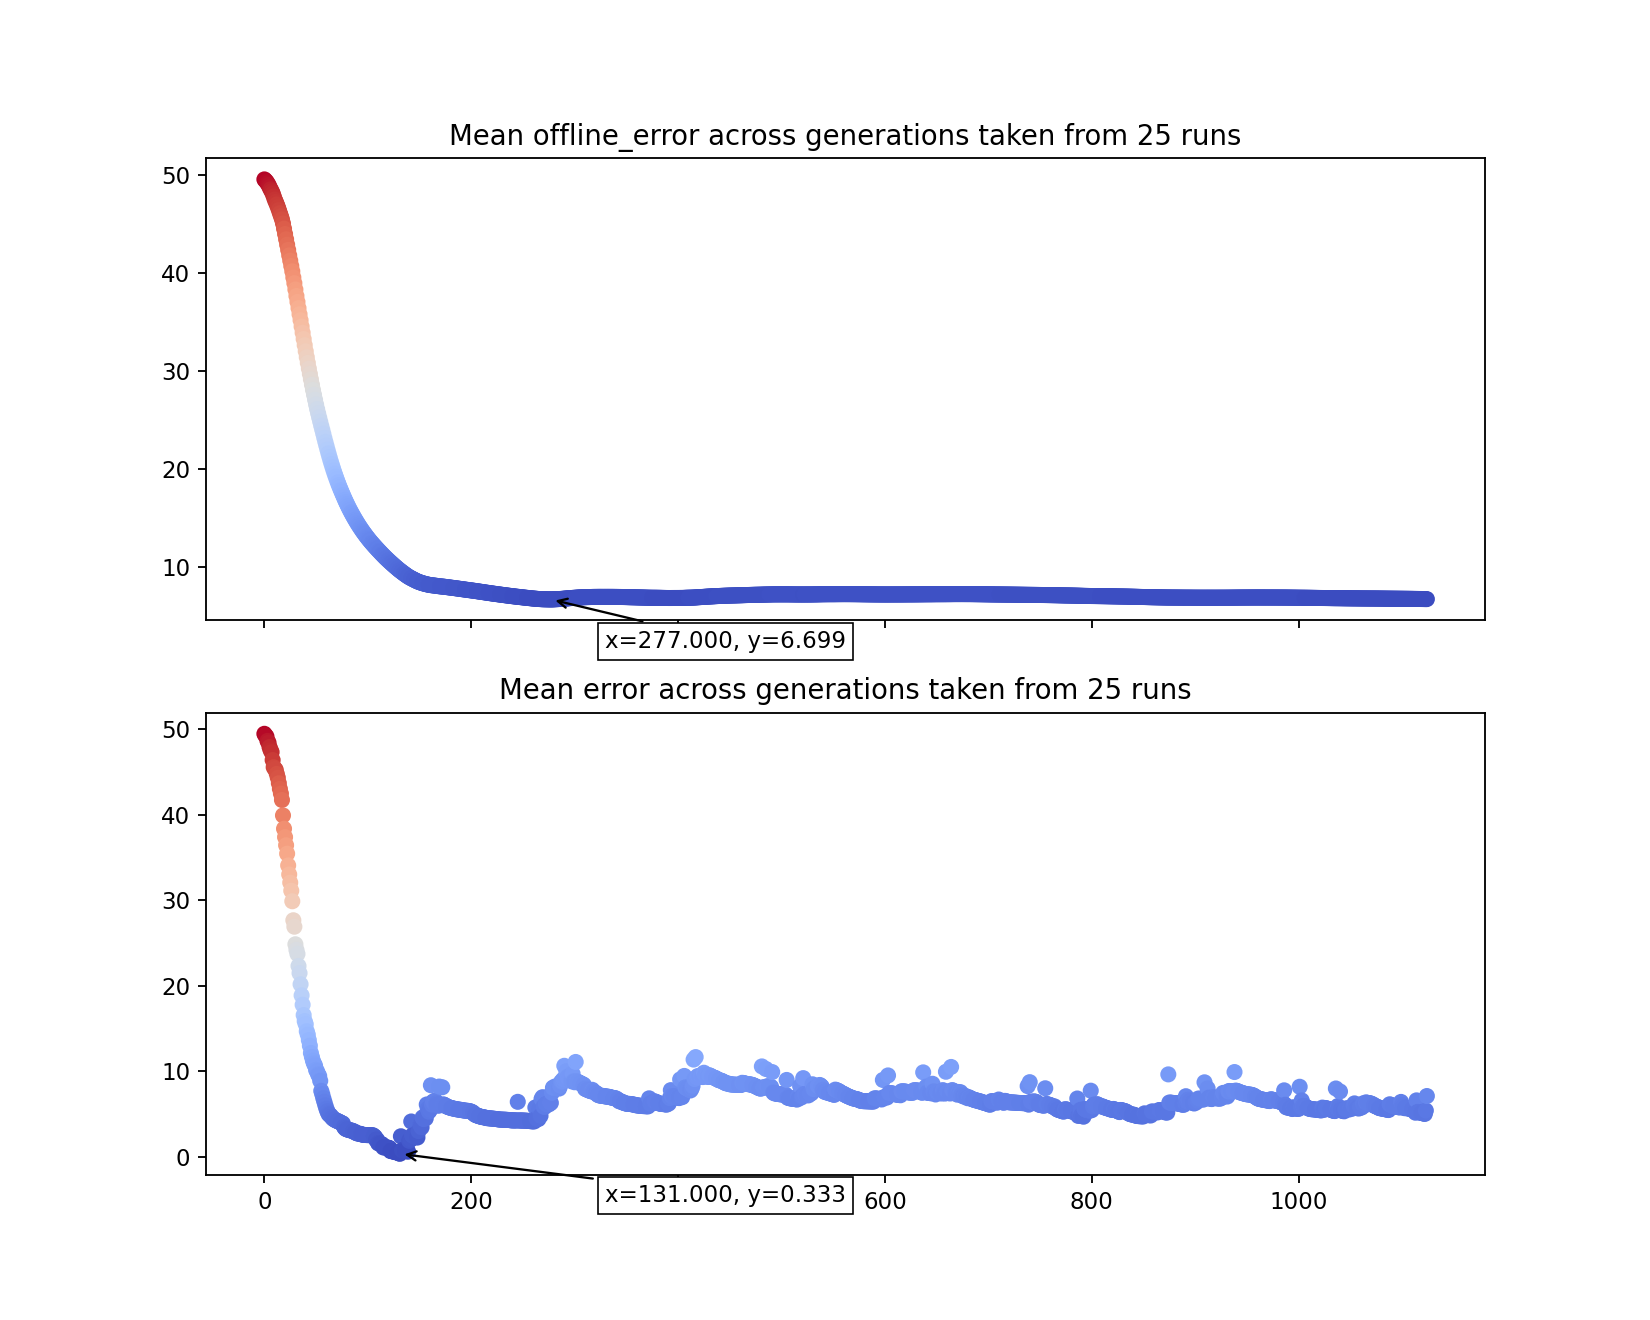

--- Mean computation time 1.6166 seconds ---
--- Mean offline error 10.8064 ---


<IPython.core.display.Javascript object>


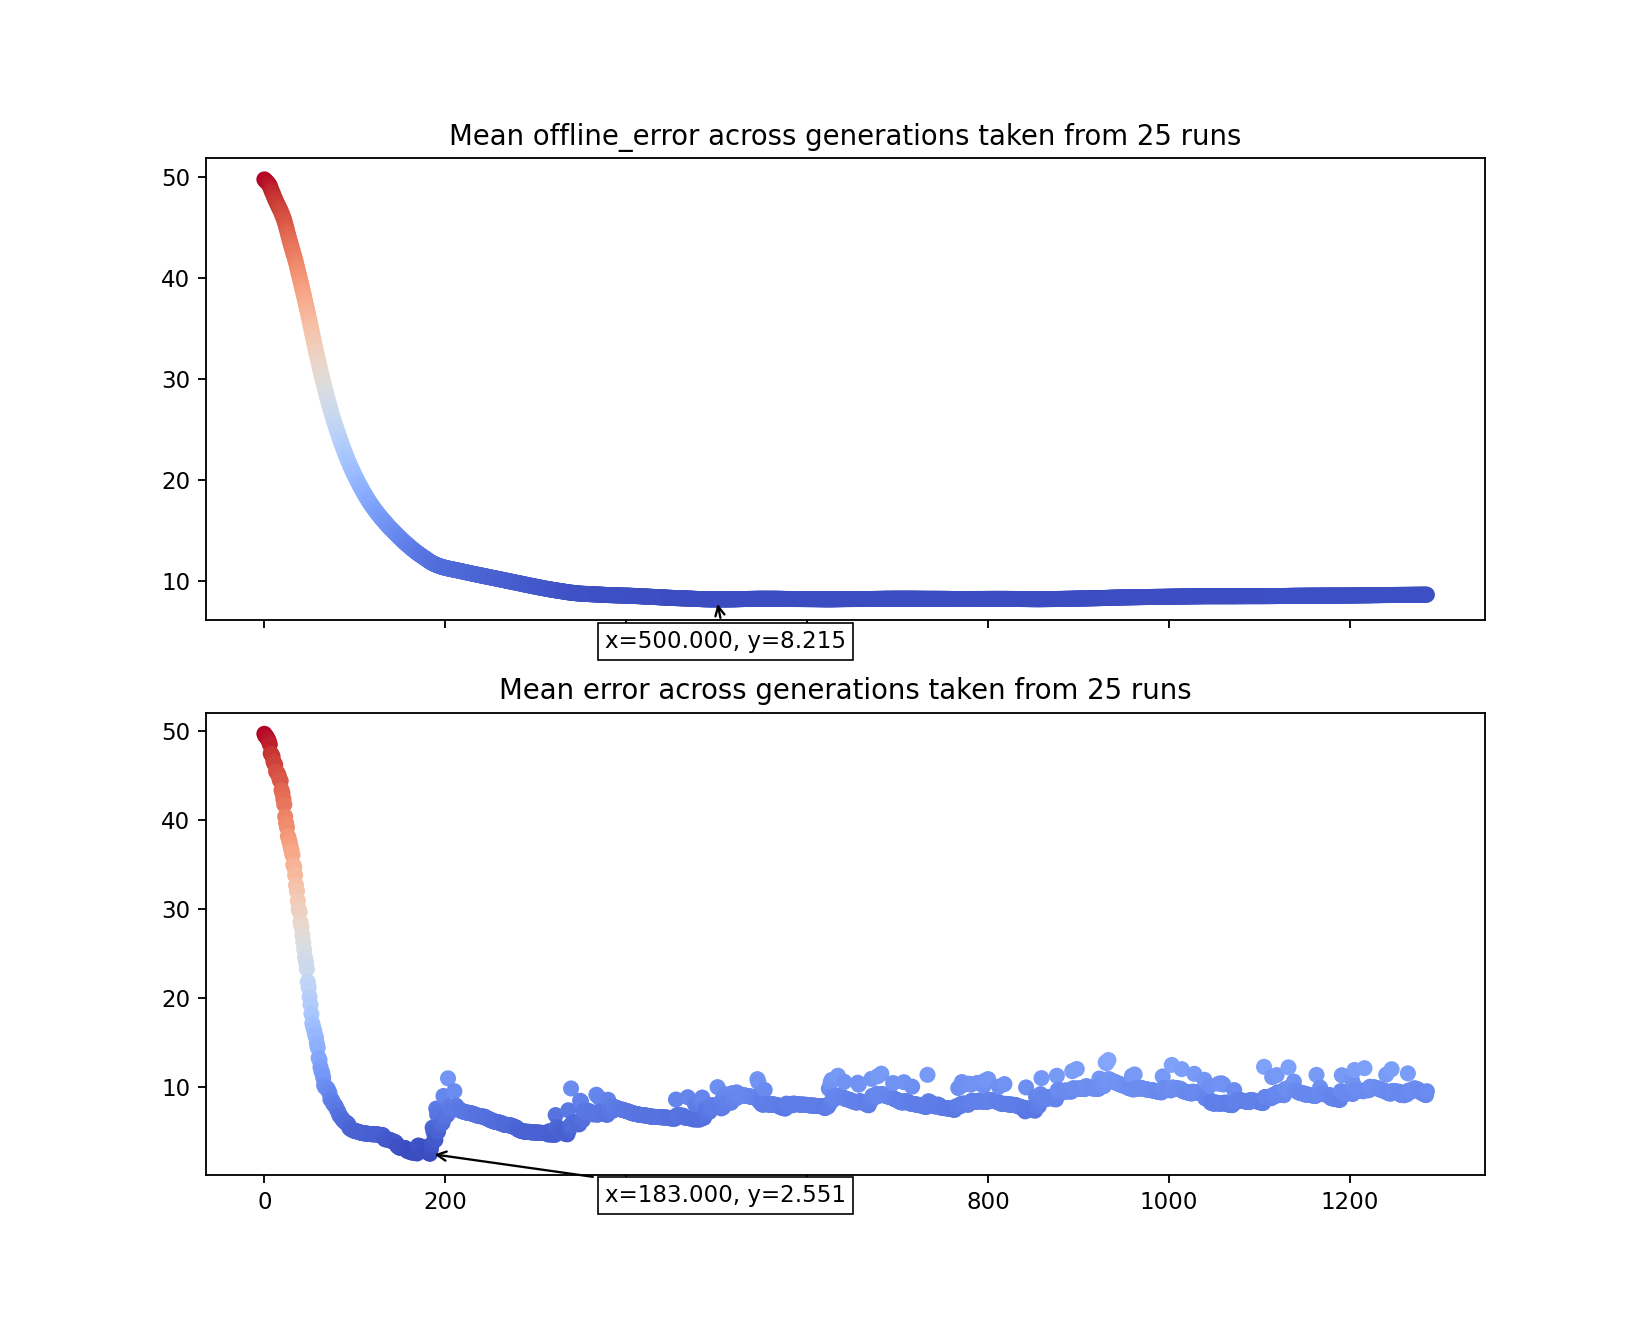

--- Mean computation time 1.6349 seconds ---
--- Mean offline error 7.8041 ---


<IPython.core.display.Javascript object>


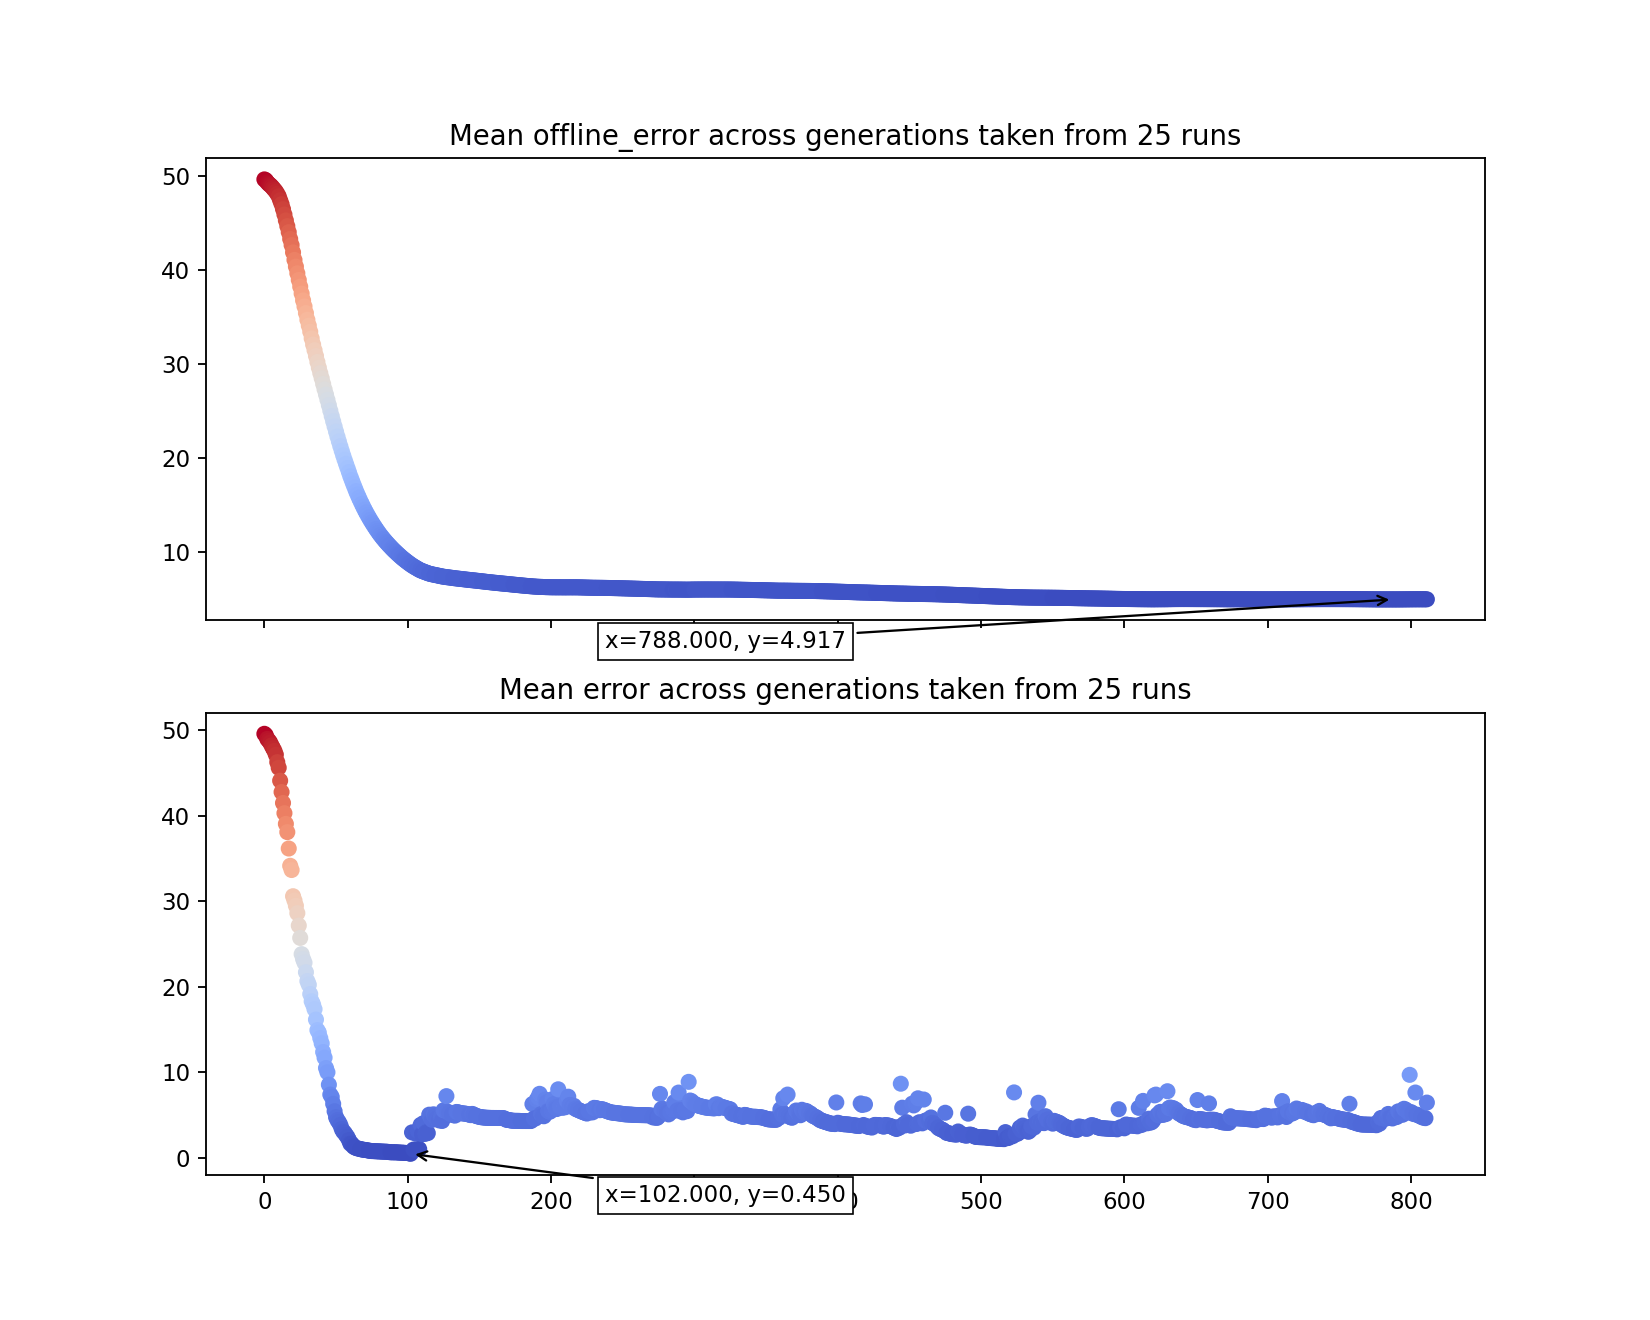

--- Mean computation time 1.6358 seconds ---
--- Mean offline error 8.7825 ---


<IPython.core.display.Javascript object>


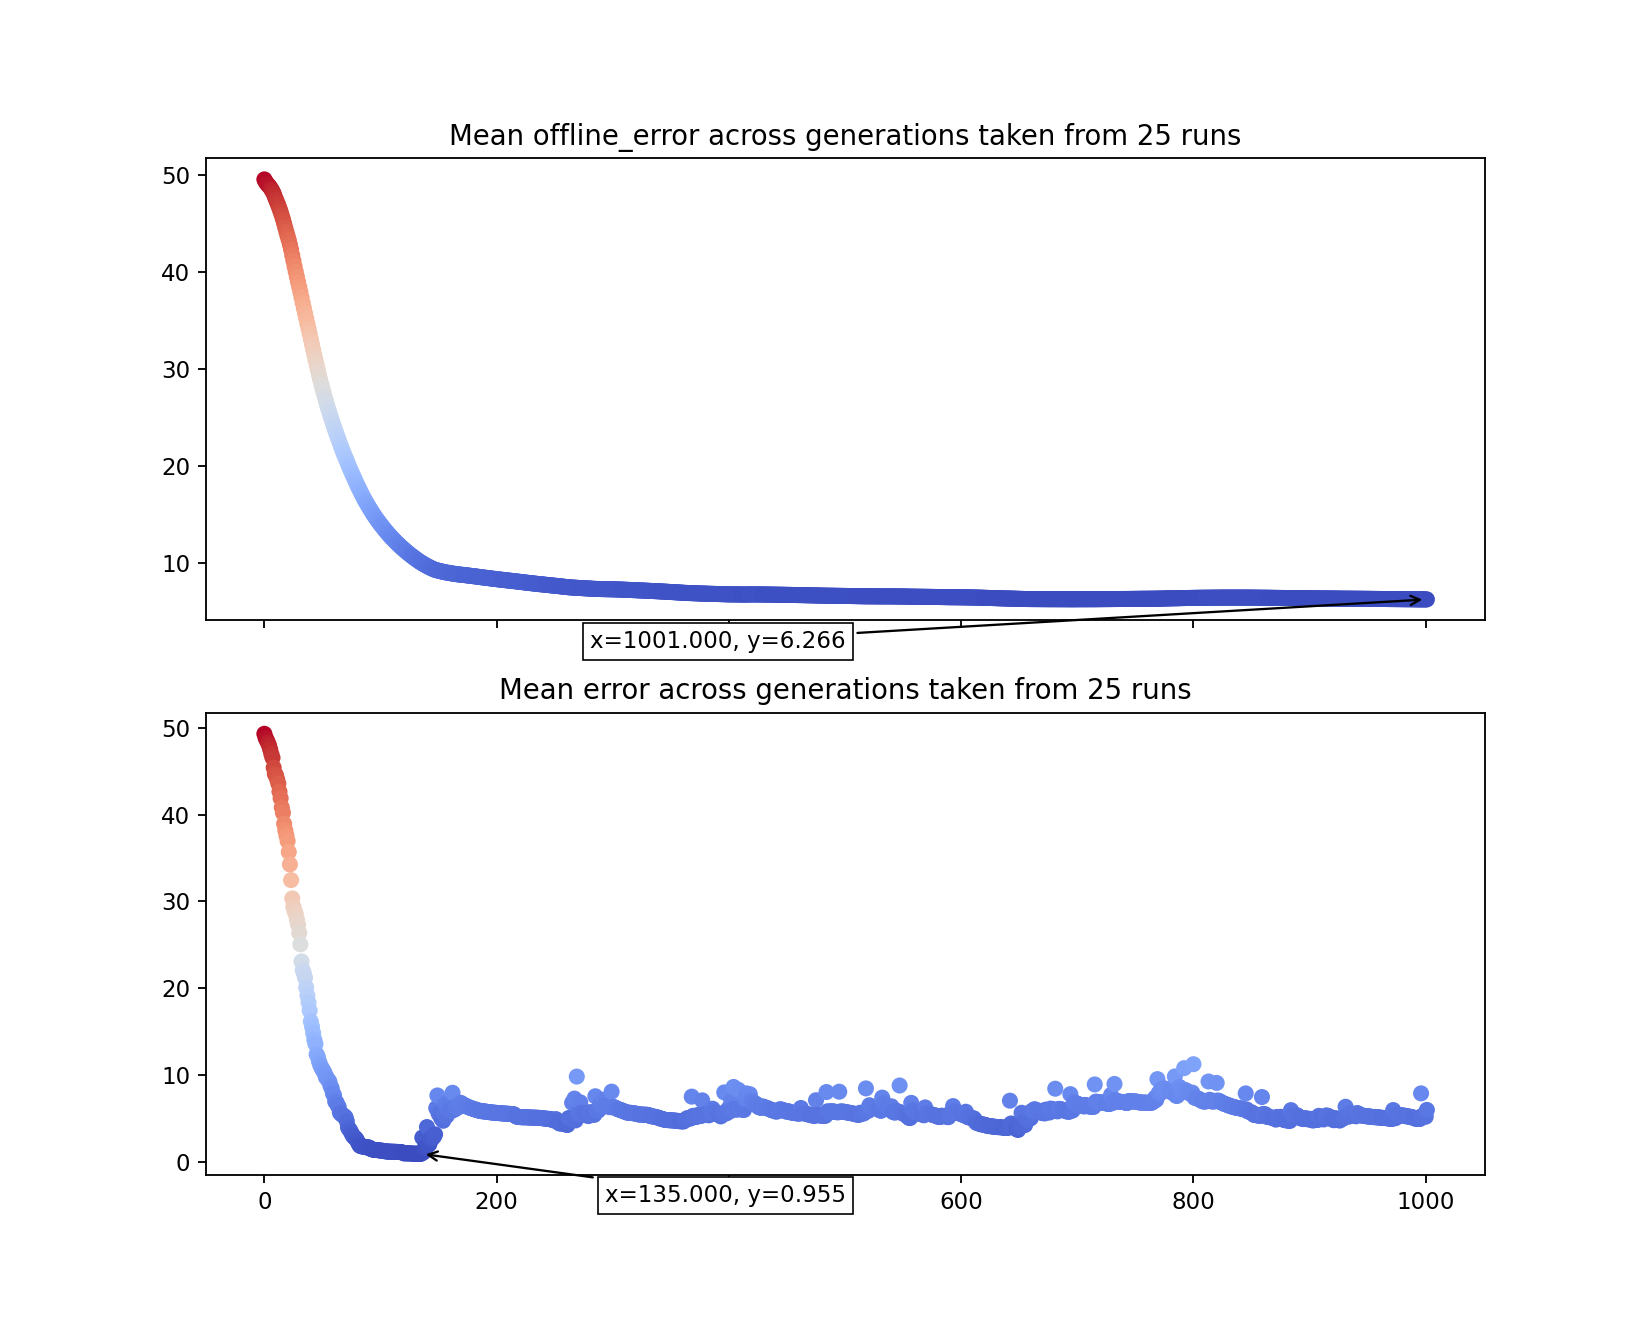

--- Mean computation time 1.6011 seconds ---
--- Mean offline error 7.5996 ---


<IPython.core.display.Javascript object>


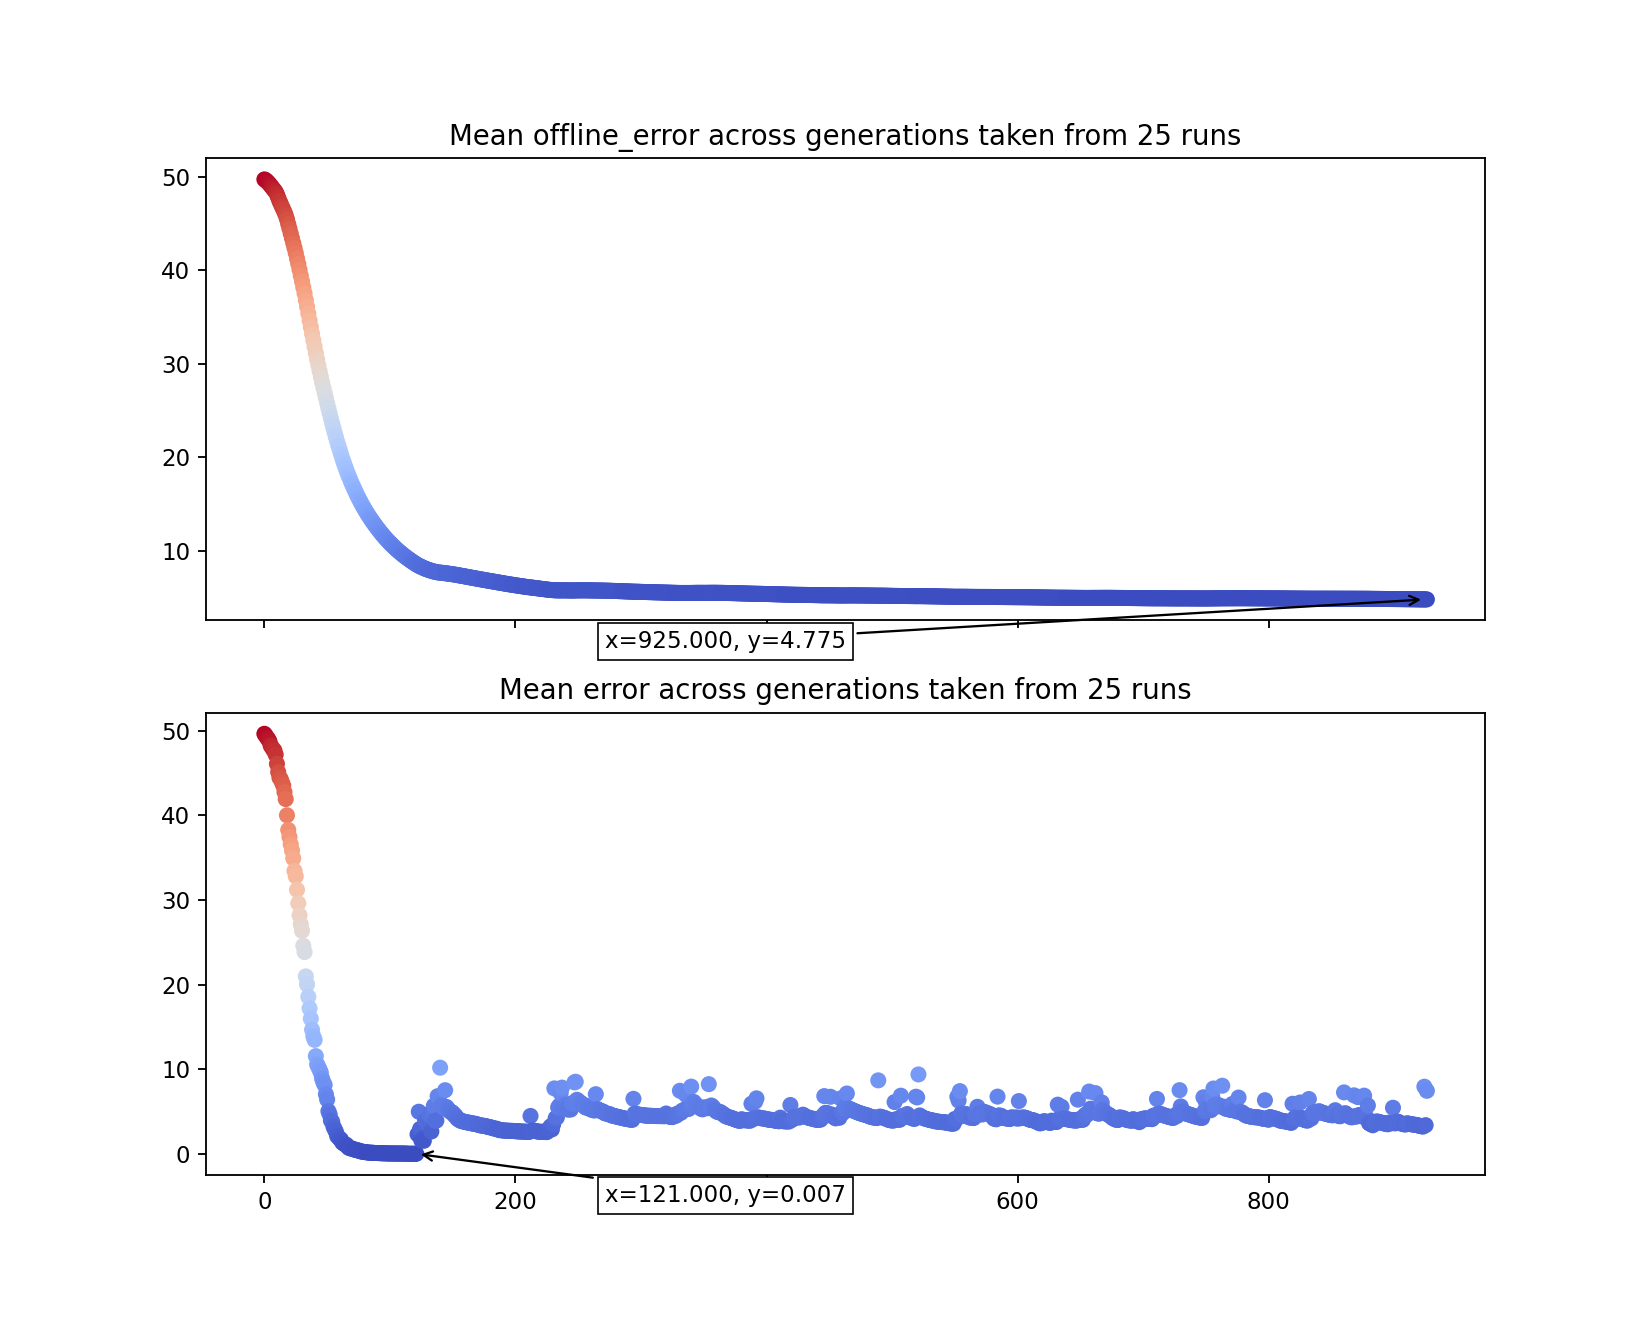

--- Mean computation time 1.5992 seconds ---
--- Mean offline error 8.1536 ---


<IPython.core.display.Javascript object>


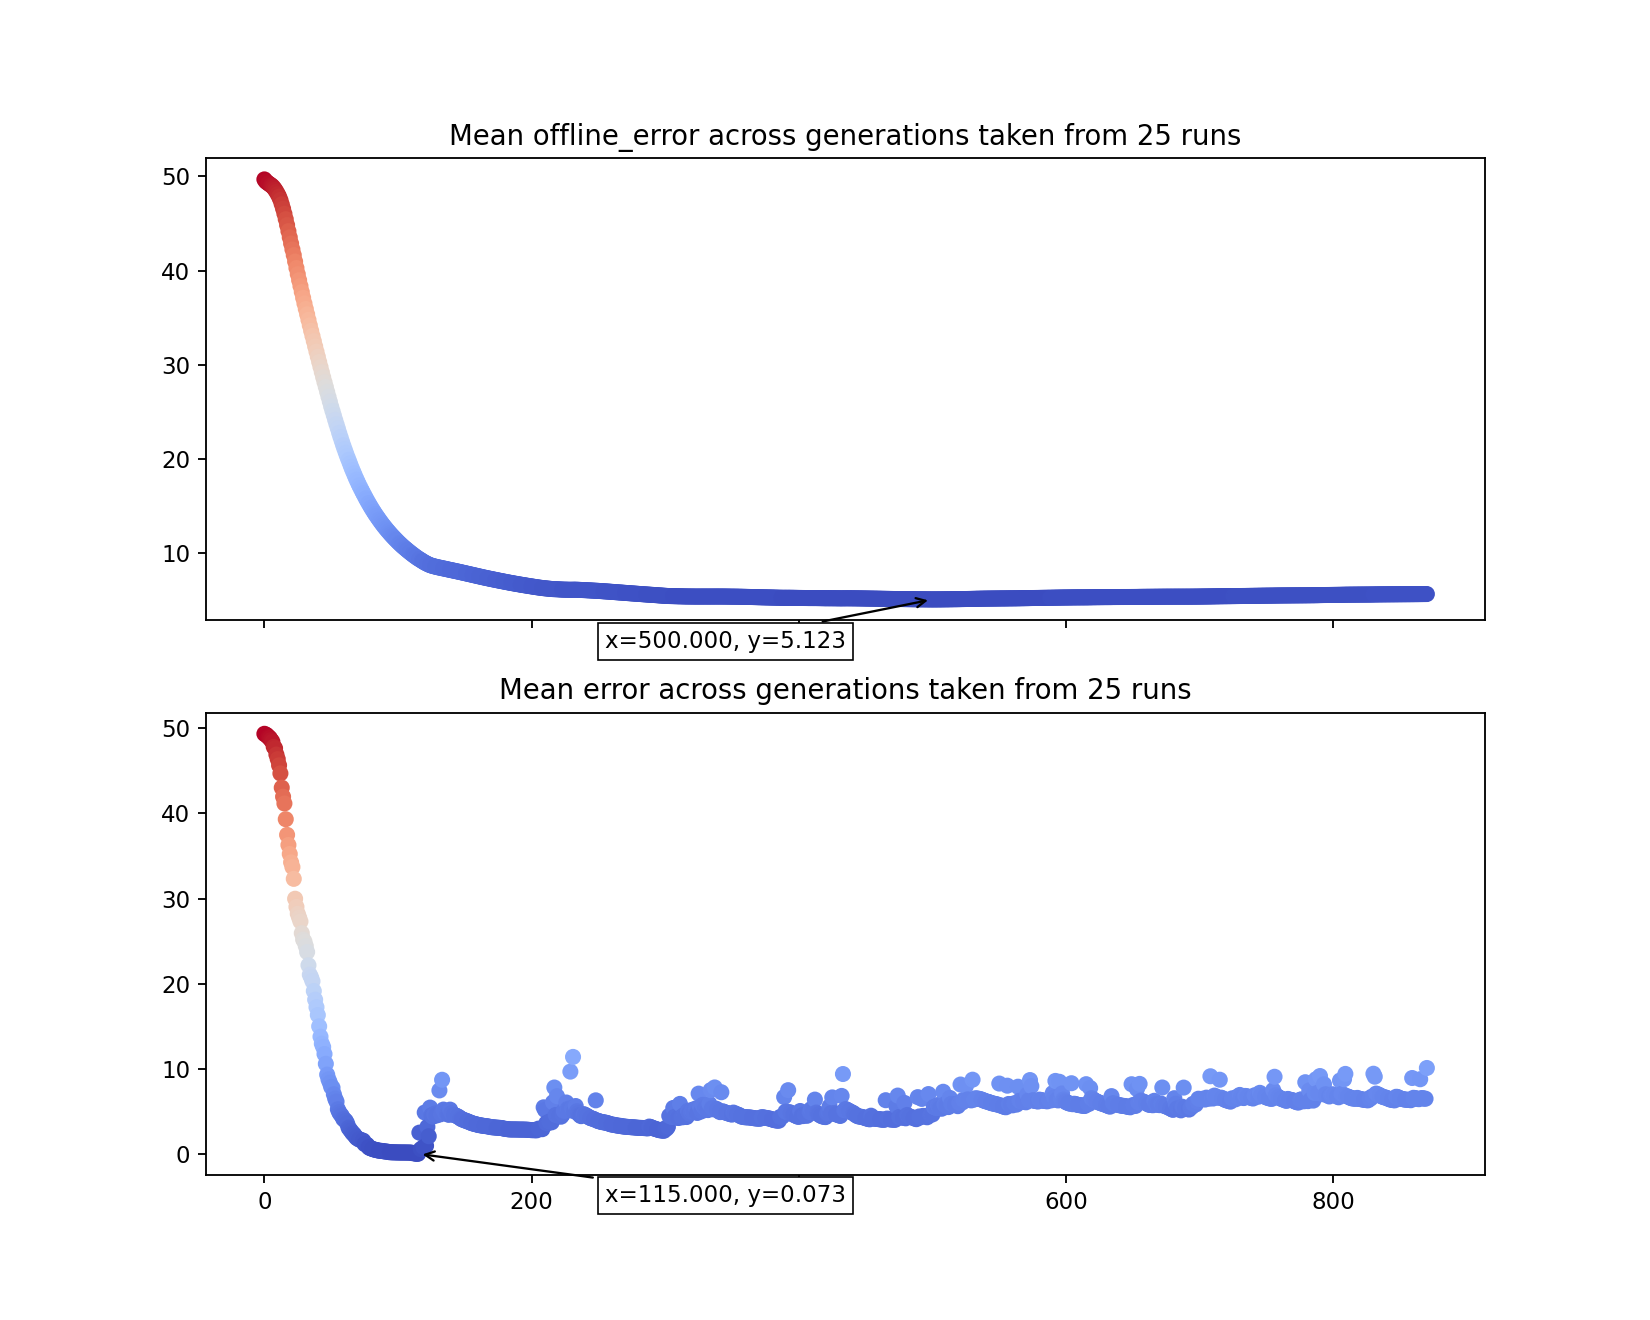

--- Mean computation time 1.6412 seconds ---
--- Mean offline error 8.6803 ---


<IPython.core.display.Javascript object>


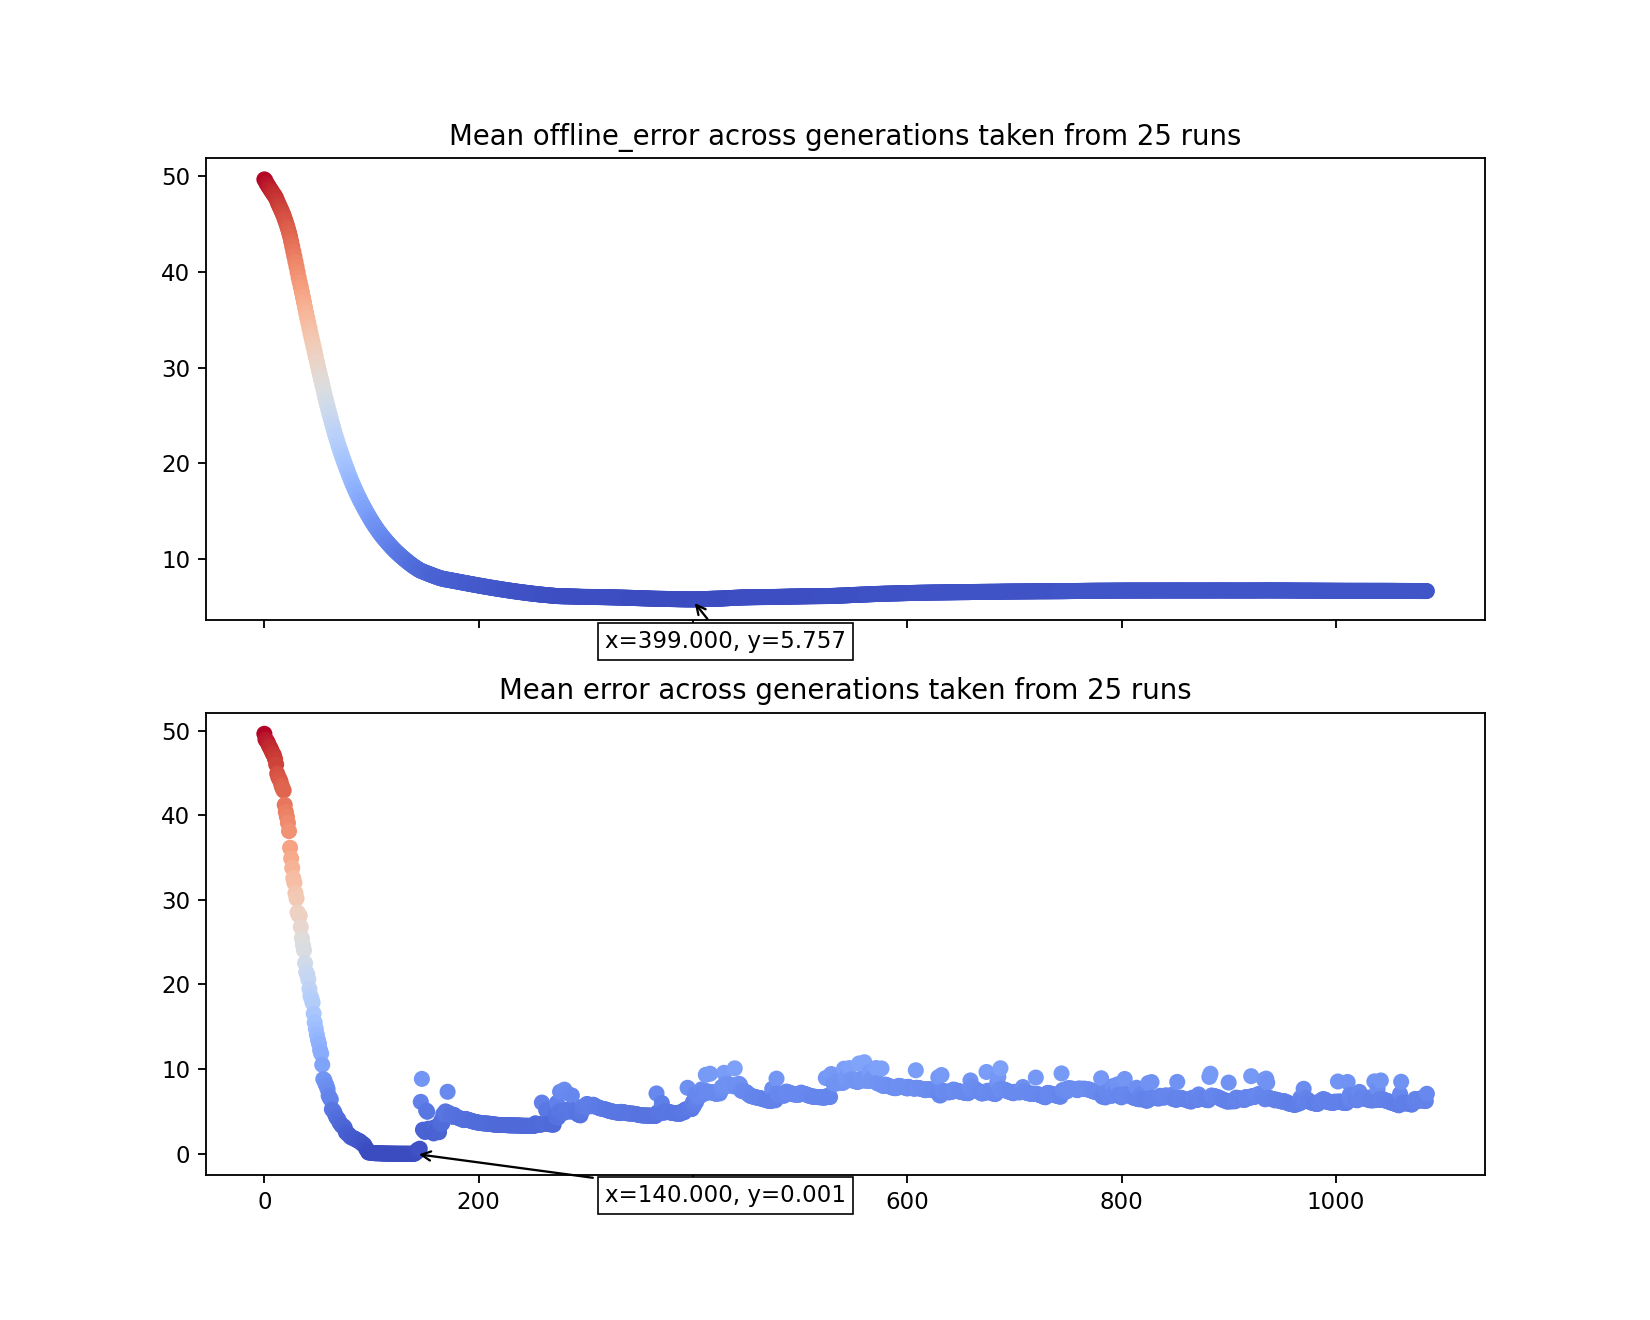

--- Mean computation time 1.7641 seconds ---
--- Mean offline error 8.6005 ---


<IPython.core.display.Javascript object>


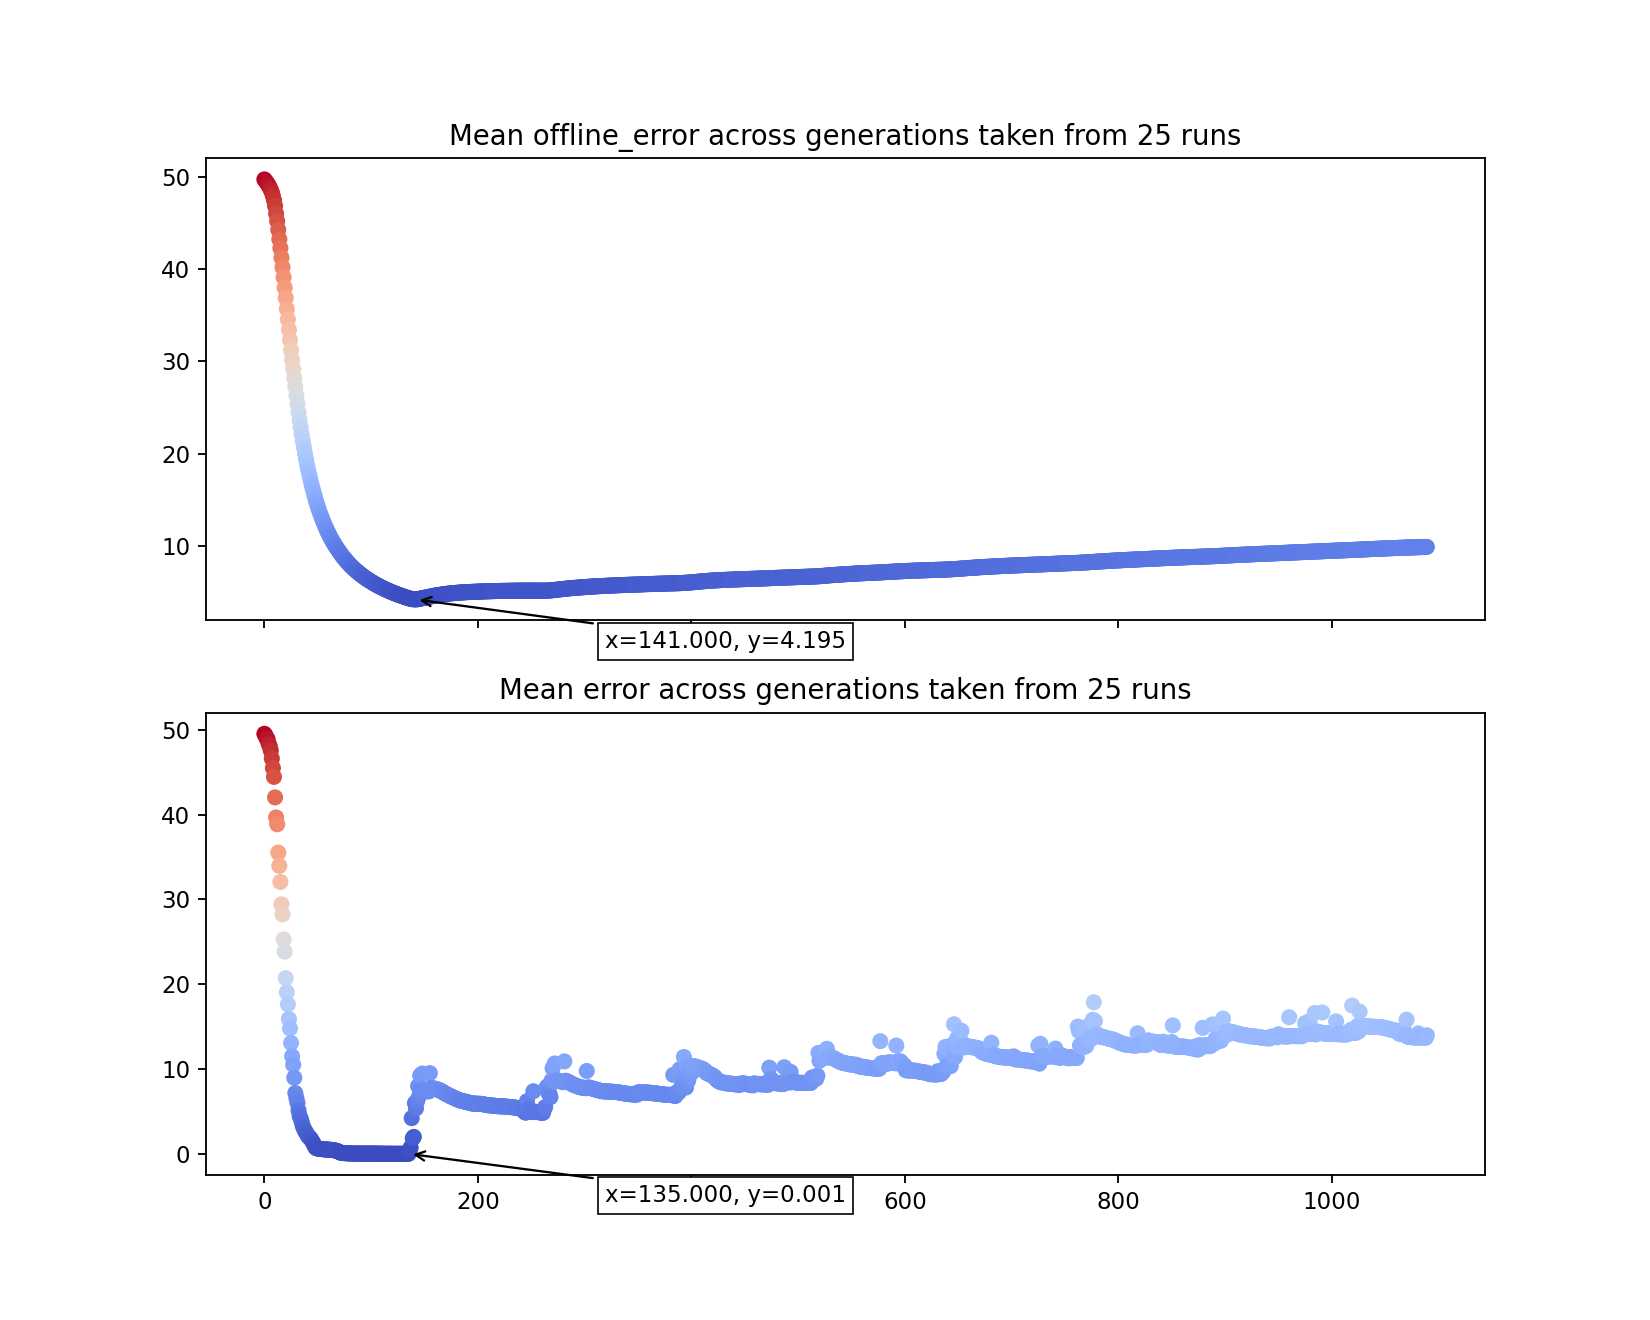

--- Mean computation time 1.5317 seconds ---
--- Mean offline error 14.1241 ---


<IPython.core.display.Javascript object>


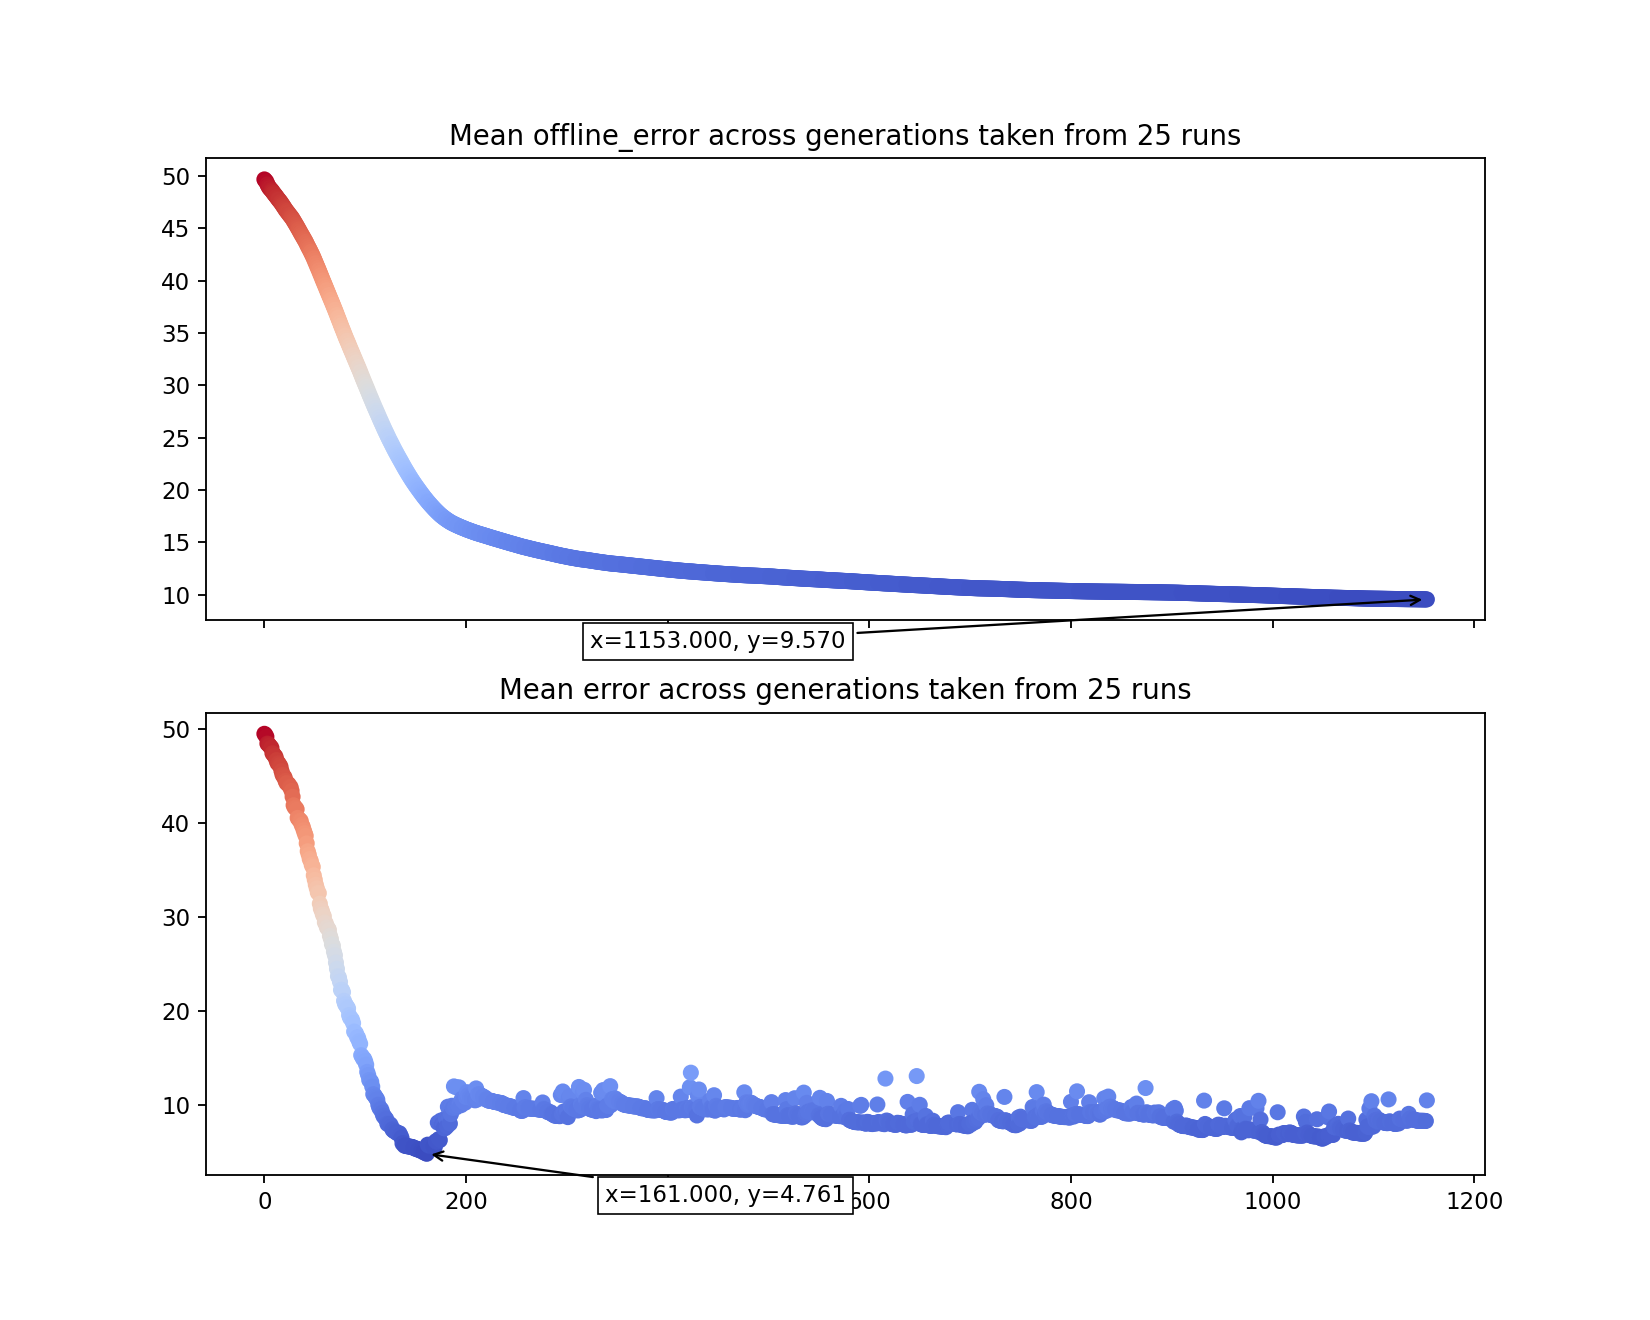

In [119]:
cfg = load_config()
run_n_times(n_runs)
cfg.NPARTICLES = 3
run_n_times(n_runs, "NPARTICLES")
cfg.NPARTICLES = 8
run_n_times(n_runs, "NPARTICLES")
cfg.NPARTICLES = 5

cfg.NSWARMS = 5
run_n_times(n_runs, "NSWARMS")
cfg.NSWARMS = 1

cfg.NEXCESS = 2
run_n_times(n_runs, "NEXCESS")
cfg.NEXCESS = 3
run_n_times(n_runs, "NEXCESS")
cfg.NEXCESS = 1

cfg.RCLOUD = 1
run_n_times(n_runs, "RCLOUD")
cfg.RCLOUD = 0.3
run_n_times(n_runs, "RCLOUD")
cfg.RCLOUD = 0.5

cfg.CHI = 0.6
run_n_times(n_runs, "CHI")
cfg.CHI = 0.82
run_n_times(n_runs, "CHI")
cfg.CHI = 0.729843788

<div style="text-align: justify">
Na podstawie wcześniejszych testów wybrano optymalny zestaw parametrów, dla których przedstawiono również wykresy wizualizujące rozkłady wartości przystosowań cząstek w co setnej iteracji, ilość subrojów od numeru iteracji oraz wartości błędów od iteracji.
</div>

--- Mean offline error 6.5724 ---


<IPython.core.display.Javascript object>


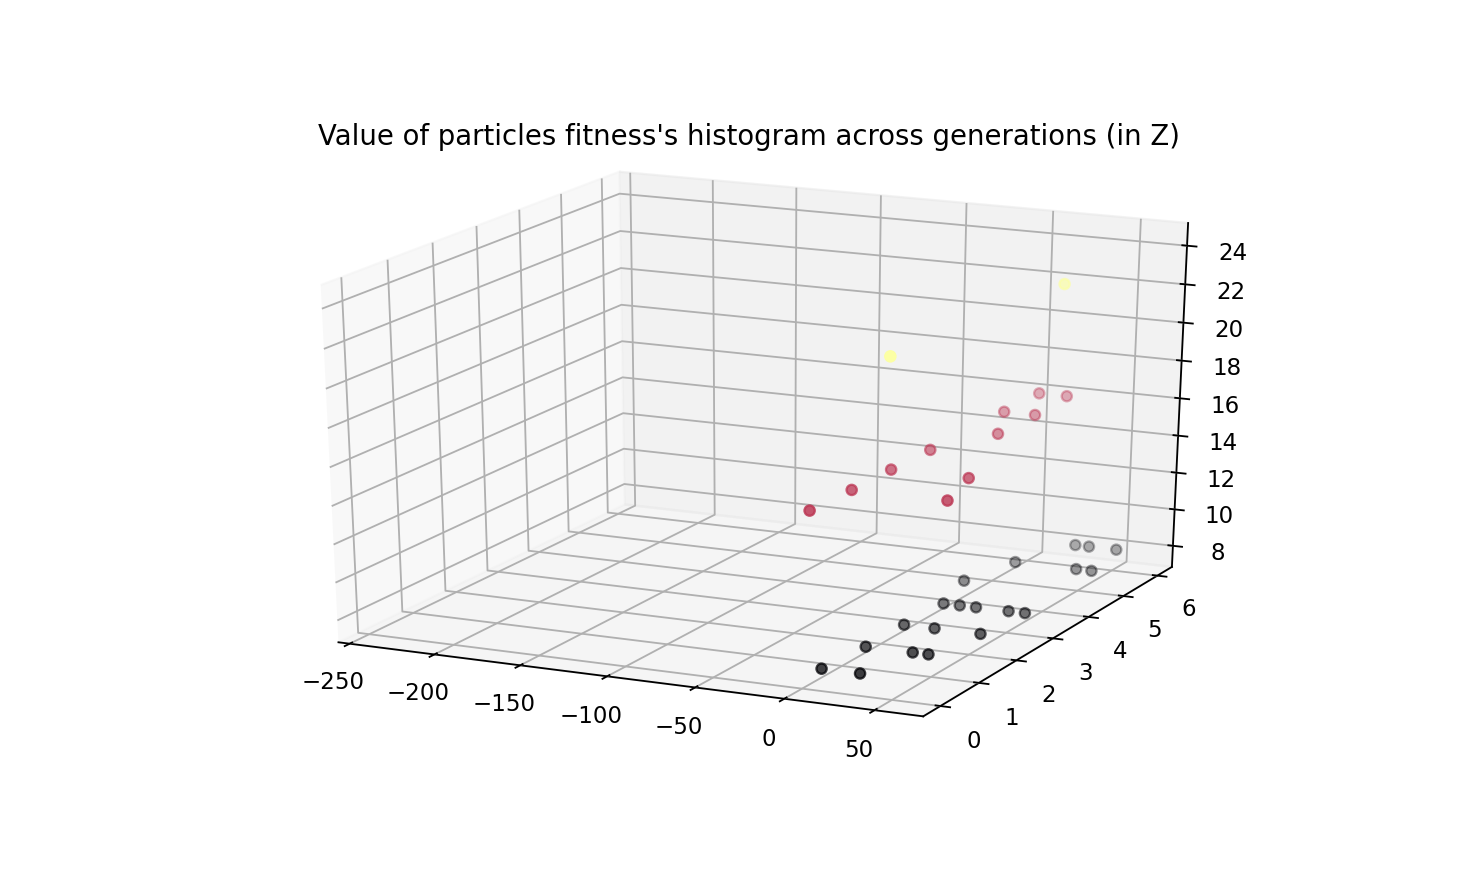

<IPython.core.display.Javascript object>


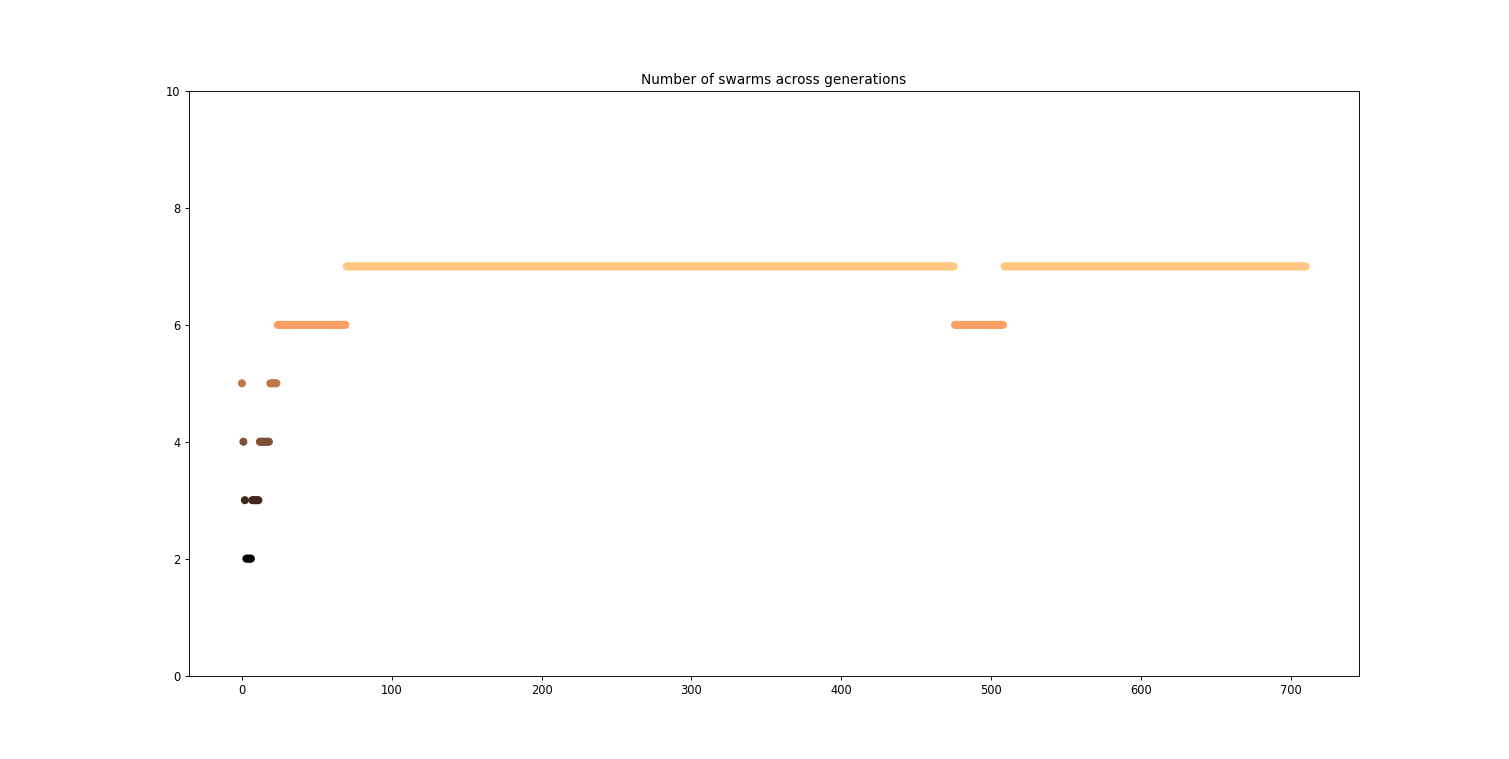

<IPython.core.display.Javascript object>


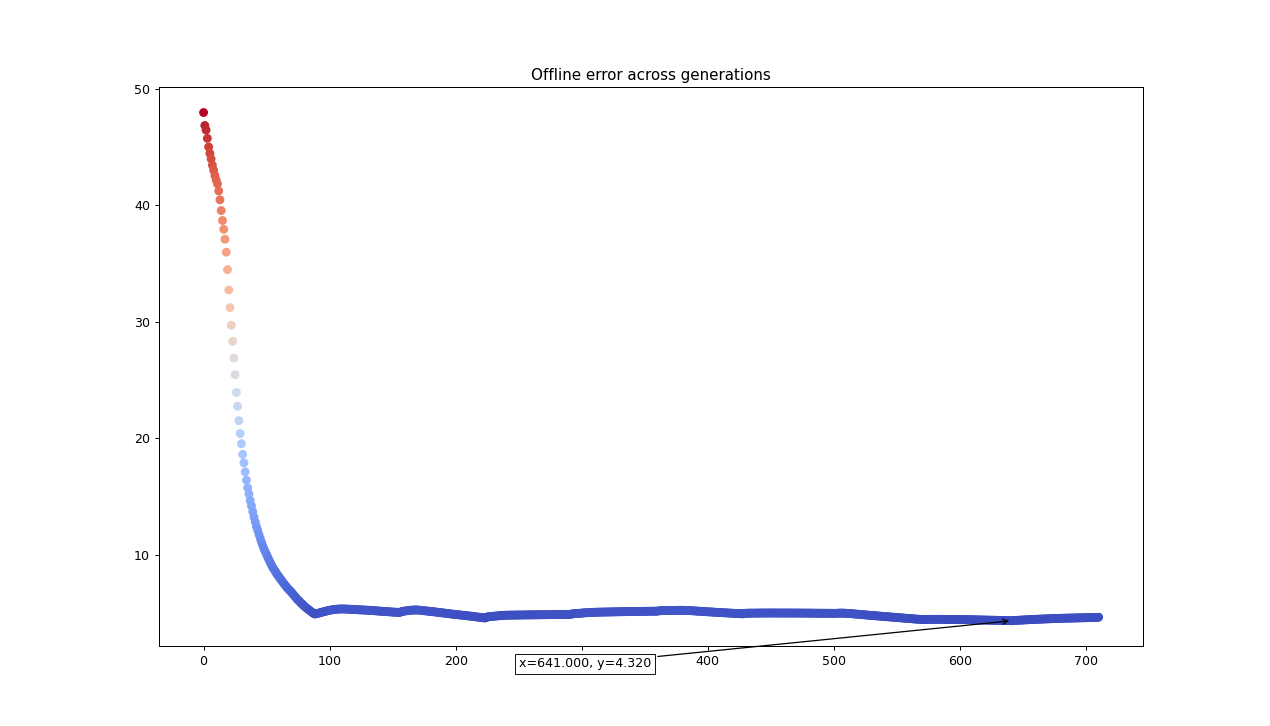

<IPython.core.display.Javascript object>


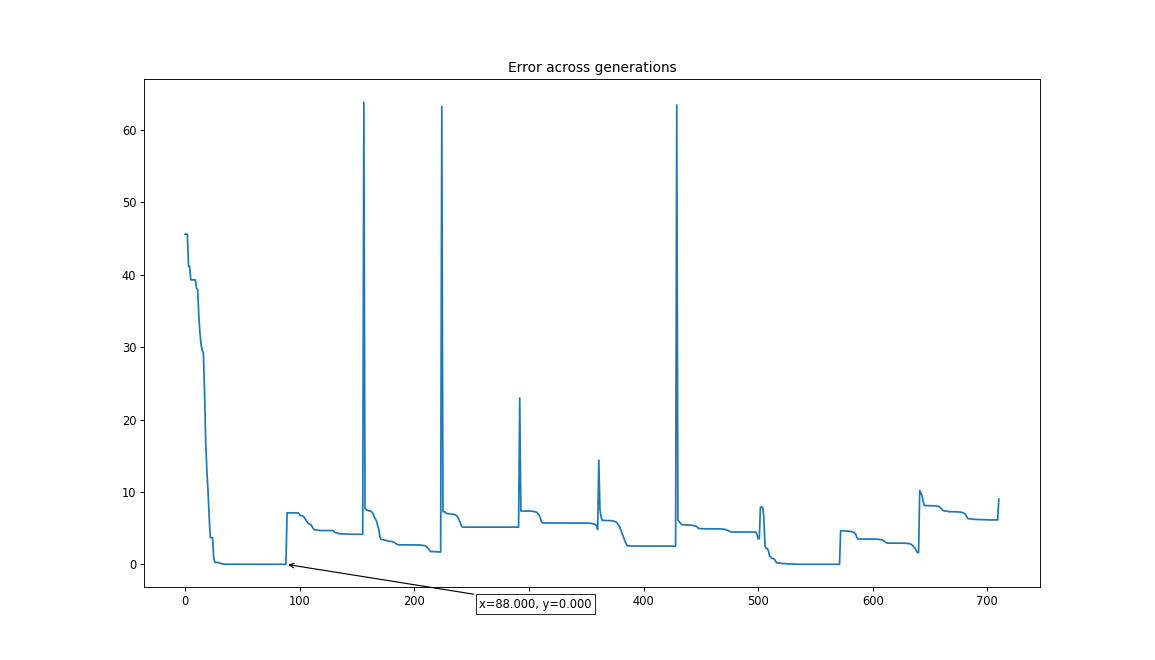

In [131]:
cfg = load_config()
cfg.NSWARMS = 5
cfg.NPARTICLES = 8
cfg.NEXCESS = 2
cfg.CHI = 0.6
re = App().run(should_plot=True)

#### Wnioski i obserwacje
<div style="text-align: justify">
    <ul>
      <li>Zmieniając wszystkie przetestowane wcześniej parametry zgodnie z uzyskanymi wynikami, udało się uzyskać wynik lepszy niż w dowolnym z poprzednich uruchomień, a więc warto jest kierować się wskazówkami uzyskanymi z testów pojedynczego parametru, ponieważ poprawy wyników z nich osiągane, nie wykluczjają się.</li>
        <li>Na wykresie <i>"Error across generations"</i> można zauważyć, że po przesunięciu się szczytów, algorytm nie tylko szybko przemieszcza subroje w nowe maksimum, ale w niektórych przypadkach przesunięć skok błędu jest drastycznie mniejszy, co prawdopodobnie związane jest z pozytywnym wpływem techniki cząstek kwantowych. Dzięki temu wartość "offline erroru" jest wysoce stabilna od momentu dopasowania się odnalezienia szczytów przez subroje (około 87 generacji).</li>
    </ul>
</div>

#### Liczba wymiarów
<div style="text-align: justify">
Przeprowadzono również testy dla ustawienia 2 wymiarów oraz ustawienia 20 wymiarów i 30 cząstęczek w każdym subroju, aby móc porównać ze sobą skuteczność algorytmów również dla innych ilości wymiarów problemu.
</div>

--- Mean computation time 1.3319 seconds ---
--- Mean offline error 1.5878 ---


<IPython.core.display.Javascript object>


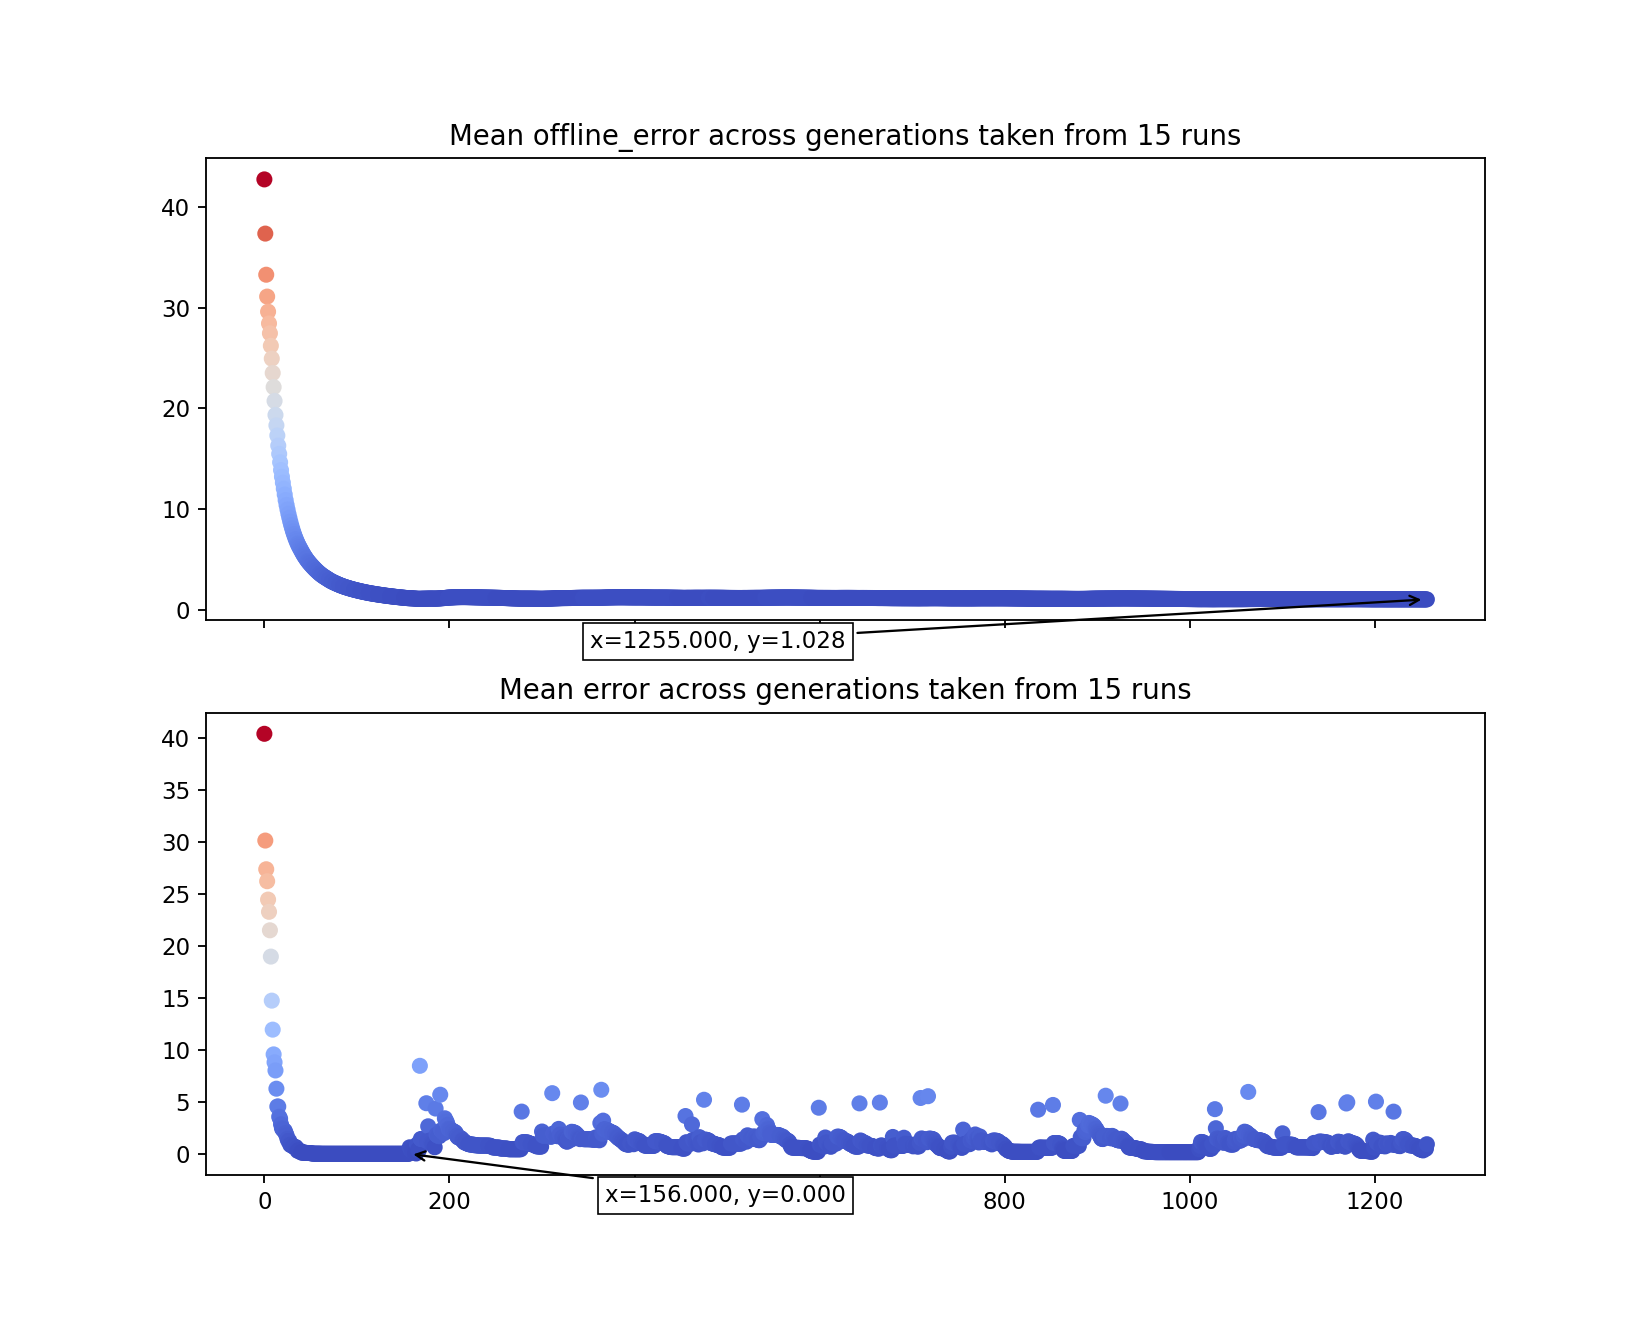

--- Mean computation time 5.3821 seconds ---
--- Mean offline error 53.2644 ---


<IPython.core.display.Javascript object>


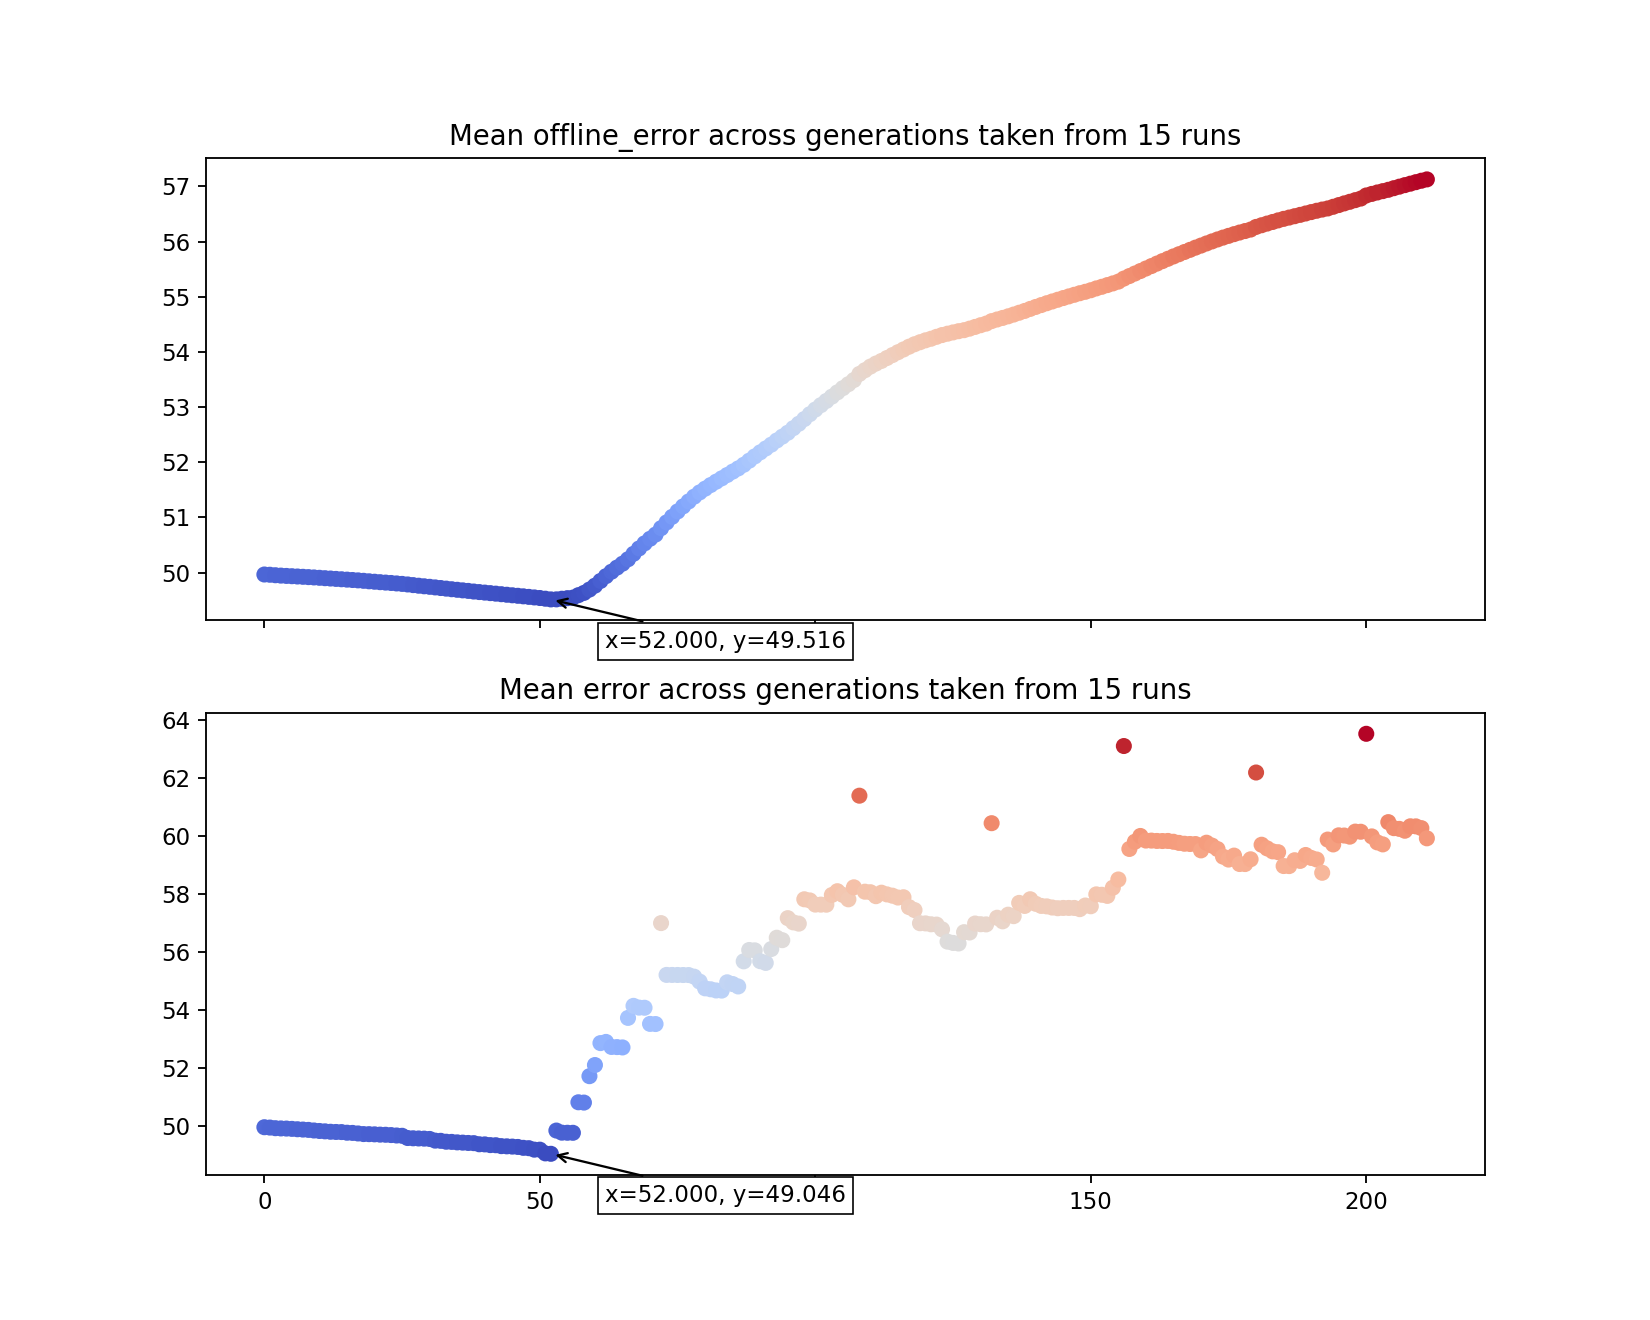

In [134]:
n_runs = 15
cfg = json.loads(json_config, object_hook = as_config)
cfg.DIMS = 2
run_n_times(n_runs, "DIMS")
cfg.DIMS = 20
cfg.NPARTICLES = 40
cfg.NEXCESS = 3
cfg.RCLOUD = 2
run_n_times(n_runs, "DIMS")

#### Liczba wymiarów
<div style="text-align: justify">
Przeprowadzono również testy dla ustawienia 2 wymiarów oraz ustawienia 20 wymiarów i 30 cząstęczek w każdym subroju, aby móc porównać ze sobą skuteczność algorytmów również dla innych ilości wymiarów problemu.
</div>

### MSPSO

In [ ]:
cfg = load_config()
cfg.TYPE = "MSPSO"
cfg.NSWARMS = 5
cfg.NPARTICLES = 3
run_n_times(n_runs)
cfg.NPARTICLES = 5
run_n_times(n_runs)
cfg.NPARTICLES = 8
run_n_times(n_runs, "NPARTICLES")
cfg.NPARTICLES = 5

cfg.DIMS = 1
run_n_times(n_runs)
cfg.DIMS = 5

cfg.NSWARMS = 3
run_n_times(n_runs, "NSWARMS")
cfg.NSWARMS = 8
run_n_times(n_runs, "NSWARMS")
cfg.NSWARMS = 5

cfg.RCLOUD = 1
run_n_times(n_runs, "RCLOUD")
cfg.RCLOUD = 0.3
run_n_times(n_runs, "RCLOUD")
cfg.RCLOUD = 0.5

cfg.CHI = 0.6
run_n_times(n_runs, "CHI")
cfg.CHI = 0.82
run_n_times(n_runs, "CHI")
cfg.CHI = 0.729843788

### BOA

In [ ]:
cfg = load_config()
cfg.TYPE = "BOA"
cfg.NSWARMS = 5
cfg.NPARTICLES = 3
run_n_times(n_runs, "NPARTICLES")
cfg.NPARTICLES = 5
run_n_times(n_runs, "NPARTICLES")
cfg.NPARTICLES = 8
run_n_times(n_runs, "NPARTICLES")
cfg.NPARTICLES = 5



--- Mean computation time 1.6104 seconds ---
--- Mean offline error 5.4679 ---


<IPython.core.display.Javascript object>


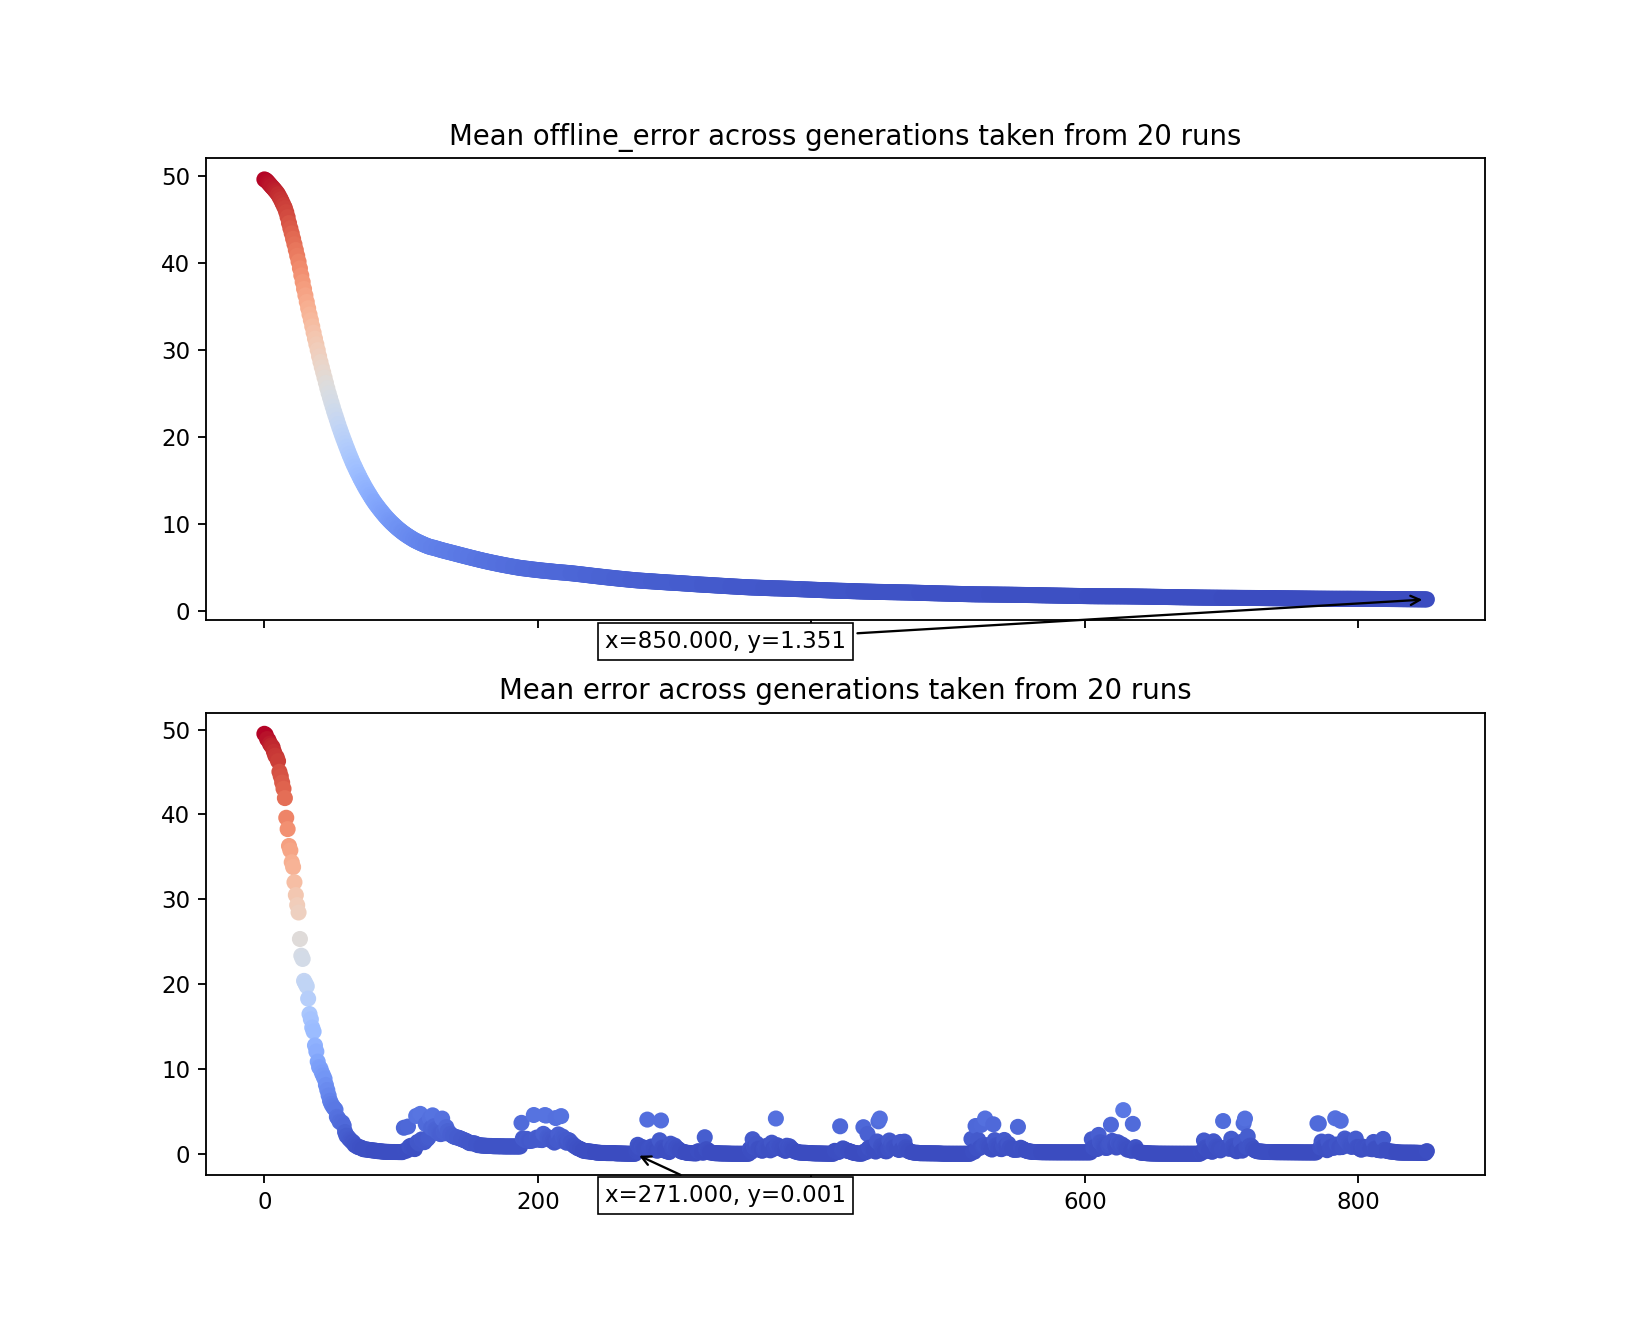

--- Mean offline error 6.3926 ---


<IPython.core.display.Javascript object>


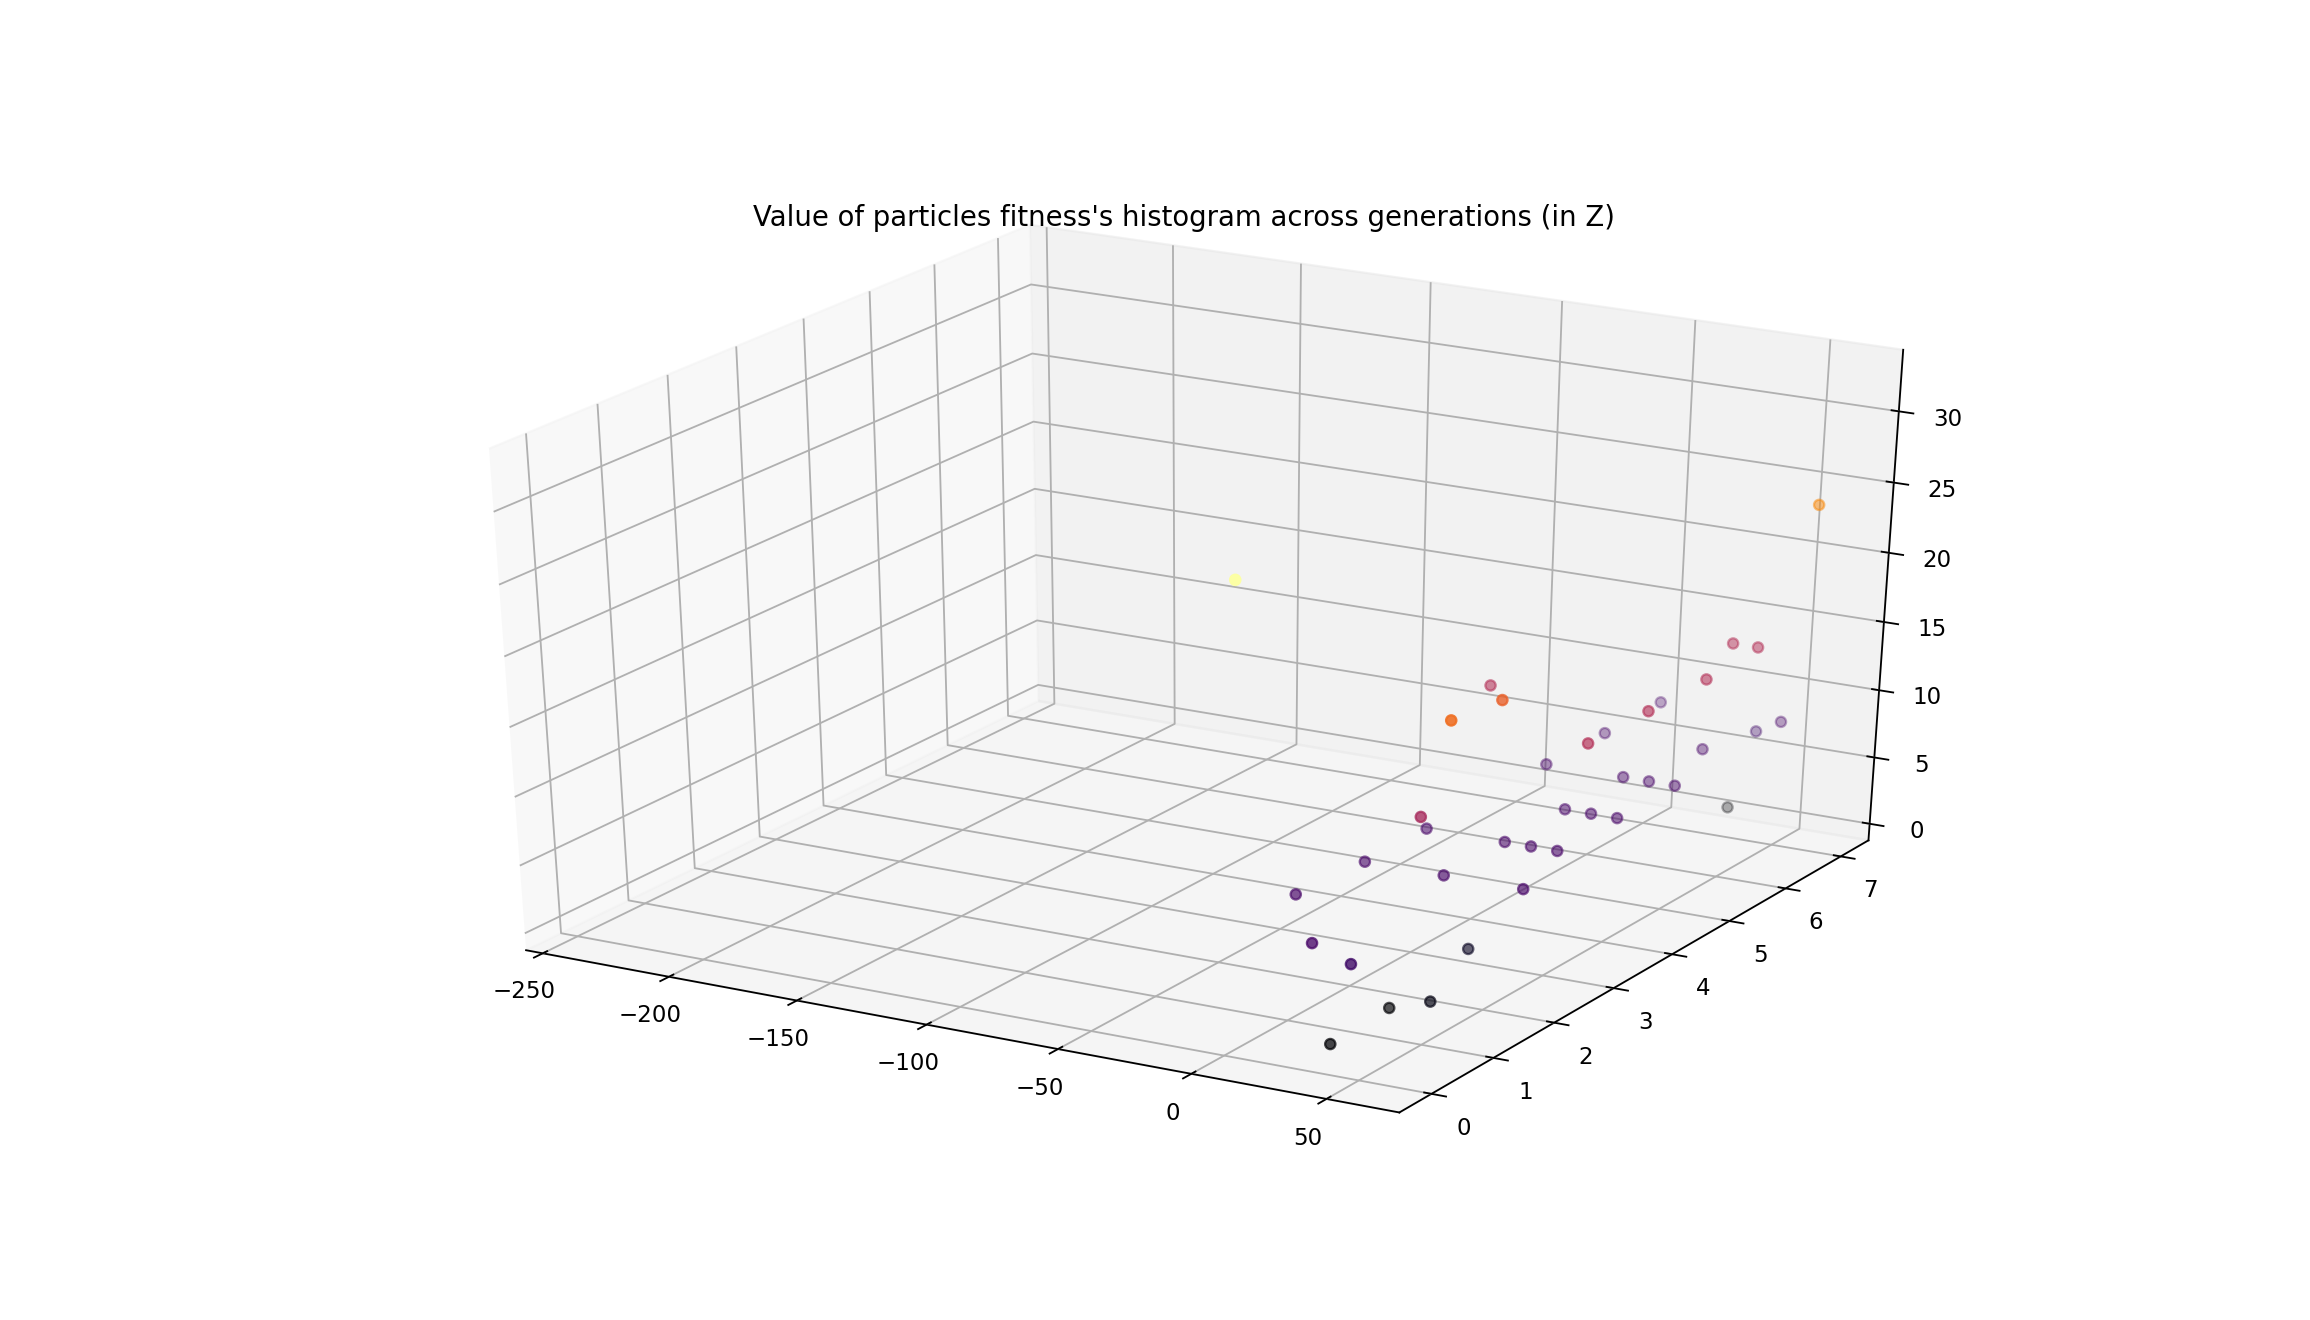

<IPython.core.display.Javascript object>


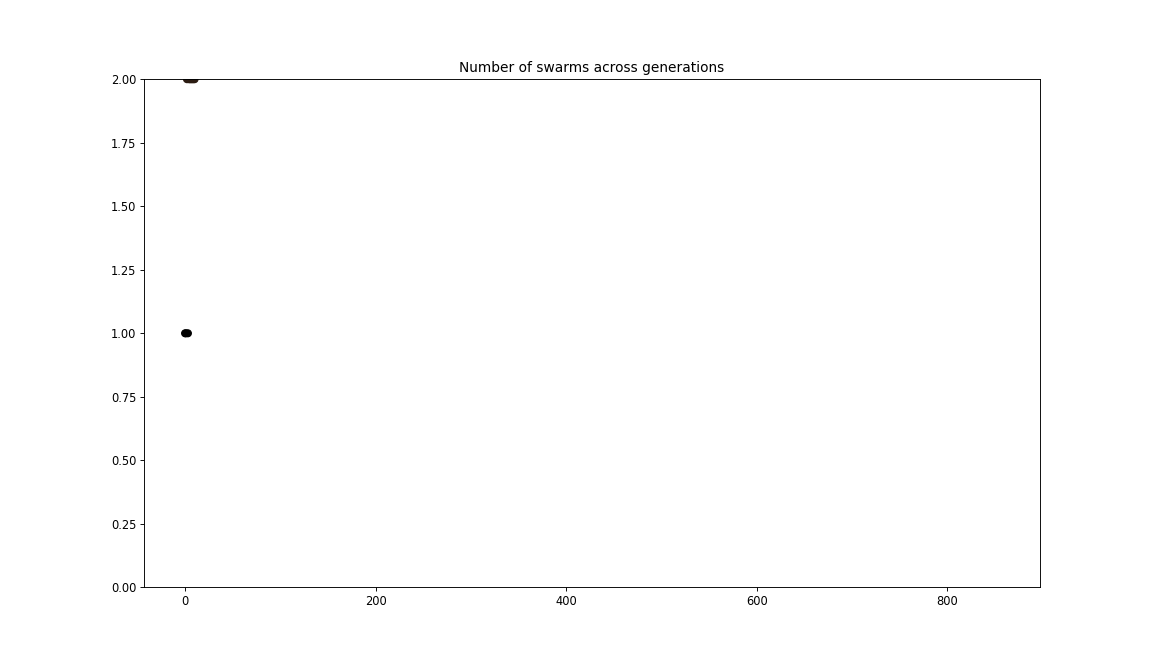

<IPython.core.display.Javascript object>


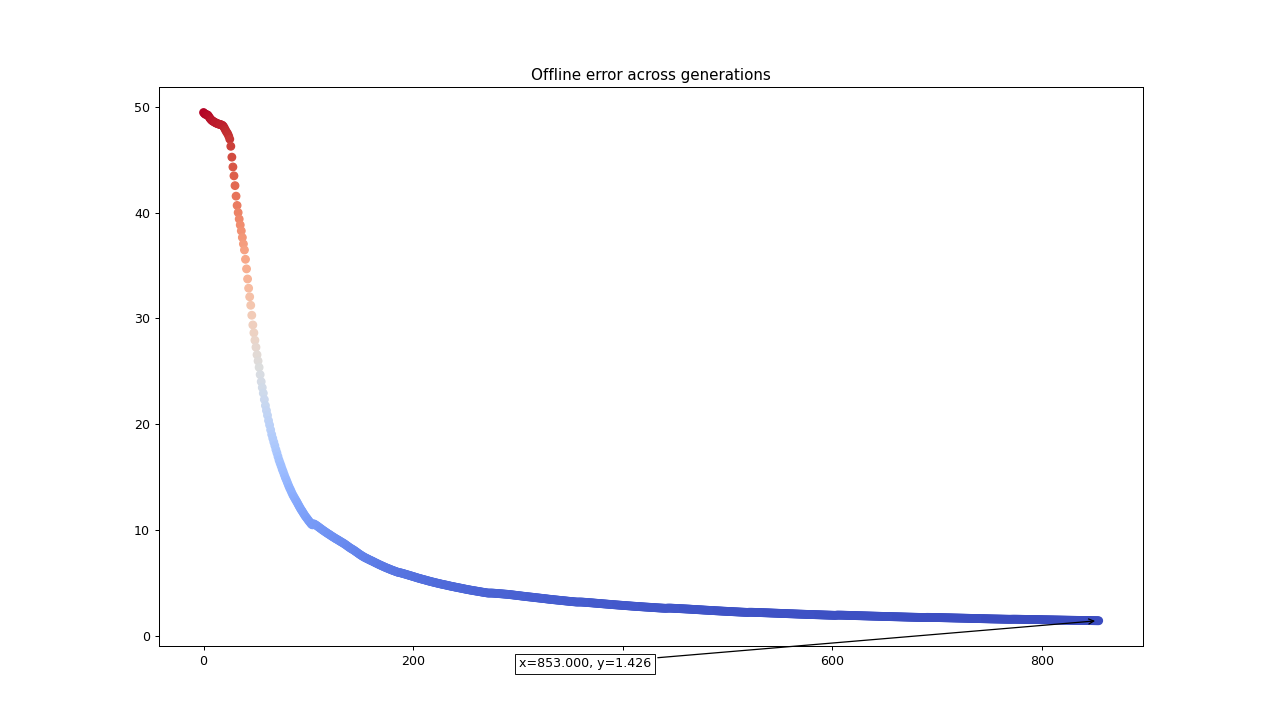

<IPython.core.display.Javascript object>


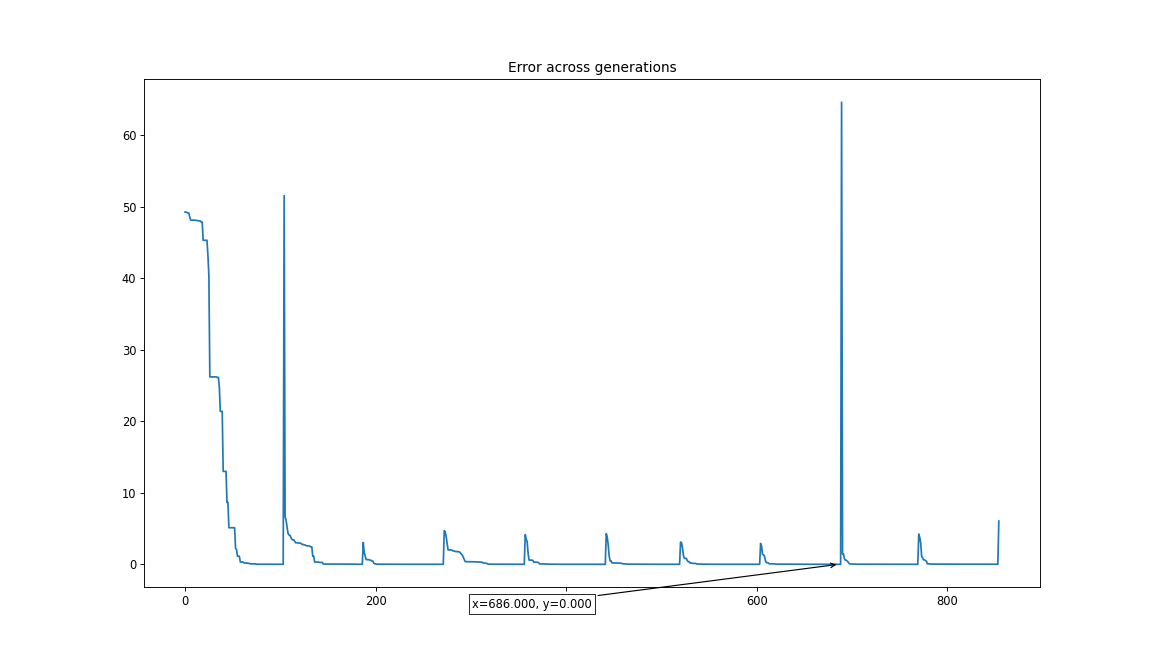

In [151]:
cfg = load_config()
cfg.TYPE = "MPSO"
cfg.NPARTICLES = 8
cfg.DIST = "nuvd"
n_runs = 20
run_n_times(n_runs)
re = App().run(should_plot=True)# cfg.TYPE = "BOA"
# cfg.NSWARMS = 10
# cfg.NPARTICLES = 8
# re = App().run(should_plot=True)